# Coursework 1  - Exercise 3

This notebook is intended to be used as a starting point for your experiments. The instructions can be found in the instructions file located under spec/coursework1.pdf. The methods provided here are just helper functions. If you want more complex graphs such as side by side comparisons of different experiments you should learn more about matplotlib and implement them. Before each experiment remember to re-initialize neural network weights and reset the data providers so you get a properly initialized experiment. For each experiment try to keep most hyperparameters the same except the one under investigation so you can understand what the effects of each are.

You should initially explore the hyperparameters involved in this algorithm. You should then carry out experiments
to compare the following (all using Adam):
- L2 regularization vs. weight decay
- constant learning rate vs. cosine annealing schedule
- no restarts in the scheduler vs. use of a warm restart

Game plan:
1. explore random L2 regularization factors
2. explore random weight decay factors
3. Assume they are decoupled and compare both
4. Explore const alpha vs. cosine annealing with adam+weight_decay
5. Explore no restarts vs warm restarts with adam+weight_decay


In [18]:
train_data = EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
valid_data = EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)
test_data = EMNISTDataProvider('test', batch_size=batch_size, rng=rng)

train_data.inputs.shape, valid_data.inputs.shape, test_data.inputs.shape

KeysView(<numpy.lib.npyio.NpzFile object at 0x7fd4864370f0>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7fd48642c080>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7fd486499f28>)


((100000, 784), (15800, 784), (15800, 784))

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def train_model_and_plot_stats(
        model, error, learning_rule, train_data, scheduler, valid_data, num_epochs, stats_interval, notebook=True):
    
    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model, error, learning_rule, train_data, scheduler, valid_data, data_monitors, notebook=notebook)
    
    # Check if we don't have any residuals
    stat = optimiser.eval_monitors(valid_data, "valid")
    print("Starting accuracy is", stat)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    
    return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2, learning_rule.learning_rate

In [4]:
def plot_stats(stat, title=None, save=False, filename=None):
    stats, keys, run_time, _, _, _, _, _ = stat
    fig, axs = plt.subplots(2,1, figsize=(6,8))
    
    if title is not None:
#         learn_rate = title.split(",")[0]
        plt.suptitle(title)

    for k in ['error(train)', 'error(valid)']:
        axs[0].plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    axs[0].legend(loc=0)
    axs[0].set_xlabel('Epoch number')

    # Plot the change in the validation and training set accuracy over training.
    for k in ['acc(train)', 'acc(valid)']:
        axs[1].plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    axs[1].legend(loc=0)
    axs[1].set_xlabel('Epoch number')
    
    if(save):
        plt.savefig(filename + ".pdf")

In [5]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider, EMNISTDataProvider
from mlp.schedulers import ConstantLearningRateScheduler, CosineAnnealingWithWarmRestarts
from mlp.initialisers import ConstantInit, GlorotUniformInit

# Seed a random number generator
seed = 11102018 
rng = np.random.RandomState(seed)
batch_size = 100
# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = EMNISTDataProvider('train', batch_size=batch_size, rng=rng)
valid_data = EMNISTDataProvider('valid', batch_size=batch_size, rng=rng)

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

# define possilb schedulers
schedulers_sgd = [ConstantLearningRateScheduler(0.005),
              CosineAnnealingWithWarmRestarts(min_learning_rate=0.0005, max_learning_rate=0.005,
                                                       total_iters_per_period=10e+30,
                                                       max_learning_rate_discount_factor=0.9,
                                                       period_iteration_expansion_factor=1.0),
              CosineAnnealingWithWarmRestarts(min_learning_rate=0.0005, max_learning_rate=0.005,
                                                       total_iters_per_period=25,
                                                       max_learning_rate_discount_factor=0.9,
                                                       period_iteration_expansion_factor=3.0)
             ]

schedulers_adam = [ConstantLearningRateScheduler(0.0001),
              CosineAnnealingWithWarmRestarts(min_learning_rate=0.00001, max_learning_rate=0.0001,
                                                       total_iters_per_period=10e+30,
                                                       max_learning_rate_discount_factor=0.9,
                                                       period_iteration_expansion_factor=1.0),
              CosineAnnealingWithWarmRestarts(min_learning_rate=0.00001, max_learning_rate=0.0001,
                                                       total_iters_per_period=25,
                                                       max_learning_rate_discount_factor=0.9,
                                                       period_iteration_expansion_factor=3.0)
             ]

KeysView(<numpy.lib.npyio.NpzFile object at 0x7fd4a84dfac8>)
KeysView(<numpy.lib.npyio.NpzFile object at 0x7fd4877d5f98>)


Starting accuracy is OrderedDict([('errorvalid', 3.861608896017226), ('accvalid', 0.014873417721518985)])


Epoch 2: 3.2s to complete
    error(train)=1.14e+00, acc(train)=6.76e-01, error(valid)=1.15e+00, acc(valid)=6.72e-01


Epoch 4: 2.9s to complete
    error(train)=8.93e-01, acc(train)=7.35e-01, error(valid)=9.10e-01, acc(valid)=7.29e-01


Epoch 6: 3.0s to complete
    error(train)=7.77e-01, acc(train)=7.66e-01, error(valid)=7.98e-01, acc(valid)=7.63e-01


Epoch 8: 3.1s to complete
    error(train)=7.05e-01, acc(train)=7.85e-01, error(valid)=7.30e-01, acc(valid)=7.77e-01


Epoch 10: 3.3s to complete
    error(train)=6.56e-01, acc(train)=7.96e-01, error(valid)=6.87e-01, acc(valid)=7.87e-01


Epoch 12: 3.1s to complete
    error(train)=6.19e-01, acc(train)=8.07e-01, error(valid)=6.54e-01, acc(valid)=7.96e-01


Epoch 14: 3.1s to complete
    error(train)=5.90e-01, acc(train)=8.14e-01, error(valid)=6.33e-01, acc(valid)=8.01e-01


Epoch 16: 3.0s to complete
    error(train)=5.65e-01, acc(train)=8.21e-01, error(valid)=6.15e-01, acc(valid)=8.07e-01


Epoch 18: 3.1s to complete
    error(train)=5.39e-01, acc(train)=8.28e-01, error(valid)=5.96e-01, acc(valid)=8.12e-01


Epoch 20: 3.0s to complete
    error(train)=5.24e-01, acc(train)=8.32e-01, error(valid)=5.85e-01, acc(valid)=8.17e-01


Epoch 22: 3.1s to complete
    error(train)=5.11e-01, acc(train)=8.33e-01, error(valid)=5.79e-01, acc(valid)=8.18e-01


Epoch 24: 3.1s to complete
    error(train)=4.94e-01, acc(train)=8.41e-01, error(valid)=5.68e-01, acc(valid)=8.20e-01


Epoch 26: 3.0s to complete
    error(train)=4.82e-01, acc(train)=8.43e-01, error(valid)=5.62e-01, acc(valid)=8.19e-01


Epoch 28: 3.2s to complete
    error(train)=4.63e-01, acc(train)=8.47e-01, error(valid)=5.47e-01, acc(valid)=8.26e-01


Epoch 30: 3.2s to complete
    error(train)=4.49e-01, acc(train)=8.53e-01, error(valid)=5.38e-01, acc(valid)=8.28e-01


Epoch 32: 3.1s to complete
    error(train)=4.42e-01, acc(train)=8.55e-01, error(valid)=5.36e-01, acc(valid)=8.28e-01


Epoch 34: 3.2s to complete
    error(train)=4.34e-01, acc(train)=8.55e-01, error(valid)=5.34e-01, acc(valid)=8.29e-01


Epoch 36: 3.0s to complete
    error(train)=4.24e-01, acc(train)=8.59e-01, error(valid)=5.33e-01, acc(valid)=8.30e-01


Epoch 38: 3.0s to complete
    error(train)=4.14e-01, acc(train)=8.63e-01, error(valid)=5.25e-01, acc(valid)=8.32e-01


Epoch 40: 3.0s to complete
    error(train)=4.08e-01, acc(train)=8.63e-01, error(valid)=5.24e-01, acc(valid)=8.31e-01


Epoch 42: 3.0s to complete
    error(train)=4.00e-01, acc(train)=8.66e-01, error(valid)=5.25e-01, acc(valid)=8.31e-01


Epoch 44: 3.0s to complete
    error(train)=3.92e-01, acc(train)=8.67e-01, error(valid)=5.19e-01, acc(valid)=8.34e-01


Epoch 46: 3.0s to complete
    error(train)=3.86e-01, acc(train)=8.69e-01, error(valid)=5.19e-01, acc(valid)=8.32e-01


Epoch 48: 3.0s to complete
    error(train)=3.77e-01, acc(train)=8.73e-01, error(valid)=5.14e-01, acc(valid)=8.35e-01


Epoch 50: 3.0s to complete
    error(train)=3.76e-01, acc(train)=8.72e-01, error(valid)=5.20e-01, acc(valid)=8.33e-01


Epoch 52: 3.0s to complete
    error(train)=3.68e-01, acc(train)=8.74e-01, error(valid)=5.15e-01, acc(valid)=8.34e-01


Epoch 54: 3.0s to complete
    error(train)=3.68e-01, acc(train)=8.74e-01, error(valid)=5.18e-01, acc(valid)=8.33e-01


Epoch 56: 2.9s to complete
    error(train)=3.57e-01, acc(train)=8.78e-01, error(valid)=5.13e-01, acc(valid)=8.35e-01


Epoch 58: 3.1s to complete
    error(train)=3.51e-01, acc(train)=8.79e-01, error(valid)=5.13e-01, acc(valid)=8.37e-01


Epoch 60: 3.0s to complete
    error(train)=3.45e-01, acc(train)=8.81e-01, error(valid)=5.13e-01, acc(valid)=8.34e-01


Epoch 62: 3.0s to complete
    error(train)=3.40e-01, acc(train)=8.83e-01, error(valid)=5.11e-01, acc(valid)=8.36e-01


Epoch 64: 3.0s to complete
    error(train)=3.38e-01, acc(train)=8.83e-01, error(valid)=5.16e-01, acc(valid)=8.35e-01


Epoch 66: 3.0s to complete
    error(train)=3.31e-01, acc(train)=8.86e-01, error(valid)=5.10e-01, acc(valid)=8.36e-01


Epoch 68: 3.0s to complete
    error(train)=3.26e-01, acc(train)=8.88e-01, error(valid)=5.09e-01, acc(valid)=8.38e-01


Epoch 70: 2.9s to complete
    error(train)=3.22e-01, acc(train)=8.89e-01, error(valid)=5.12e-01, acc(valid)=8.36e-01


Epoch 72: 2.9s to complete
    error(train)=3.23e-01, acc(train)=8.87e-01, error(valid)=5.21e-01, acc(valid)=8.36e-01


Epoch 74: 3.0s to complete
    error(train)=3.12e-01, acc(train)=8.92e-01, error(valid)=5.14e-01, acc(valid)=8.39e-01


Epoch 76: 3.0s to complete
    error(train)=3.11e-01, acc(train)=8.91e-01, error(valid)=5.16e-01, acc(valid)=8.35e-01


Epoch 78: 3.0s to complete
    error(train)=3.09e-01, acc(train)=8.91e-01, error(valid)=5.17e-01, acc(valid)=8.36e-01


Epoch 80: 3.0s to complete
    error(train)=3.03e-01, acc(train)=8.93e-01, error(valid)=5.20e-01, acc(valid)=8.35e-01


Epoch 82: 2.9s to complete
    error(train)=3.02e-01, acc(train)=8.94e-01, error(valid)=5.23e-01, acc(valid)=8.37e-01


Epoch 84: 3.0s to complete
    error(train)=2.98e-01, acc(train)=8.95e-01, error(valid)=5.23e-01, acc(valid)=8.36e-01


Epoch 86: 2.9s to complete
    error(train)=2.94e-01, acc(train)=8.96e-01, error(valid)=5.28e-01, acc(valid)=8.34e-01


Epoch 88: 3.0s to complete
    error(train)=2.90e-01, acc(train)=8.98e-01, error(valid)=5.26e-01, acc(valid)=8.37e-01


Epoch 90: 3.0s to complete
    error(train)=2.82e-01, acc(train)=9.01e-01, error(valid)=5.22e-01, acc(valid)=8.36e-01


Epoch 92: 3.0s to complete
    error(train)=2.87e-01, acc(train)=8.97e-01, error(valid)=5.36e-01, acc(valid)=8.36e-01


Epoch 94: 2.9s to complete
    error(train)=2.82e-01, acc(train)=8.99e-01, error(valid)=5.37e-01, acc(valid)=8.34e-01


Epoch 96: 3.0s to complete
    error(train)=2.77e-01, acc(train)=9.01e-01, error(valid)=5.36e-01, acc(valid)=8.34e-01


Epoch 98: 2.9s to complete
    error(train)=2.71e-01, acc(train)=9.03e-01, error(valid)=5.33e-01, acc(valid)=8.35e-01


Epoch 100: 2.9s to complete
    error(train)=2.71e-01, acc(train)=9.04e-01, error(valid)=5.37e-01, acc(valid)=8.37e-01


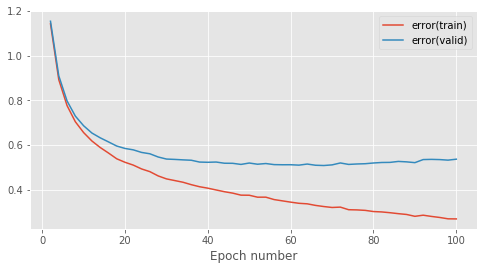

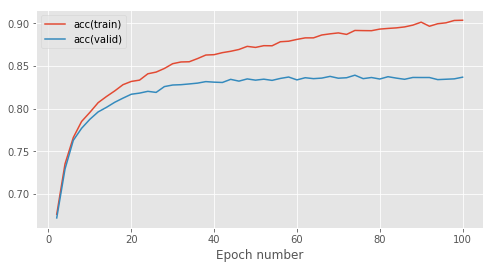

In [26]:
# Simple model with SGD and 3 hidden layers. To be used as baseline

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.learning_rules import AdamLearningRule
from mlp.schedulers import ConstantLearningRateScheduler, CosineAnnealingWithWarmRestarts
from mlp.optimisers import Optimiser
from mlp.penalties import L2Penalty


#setup hyperparameters
learning_rate = 0.0001
batch = 200
num_epochs = 100
stats_interval = 2
input_dim, output_dim, hidden_dim = 784, 47, 100

train_data.reset()
valid_data.reset()
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate)

scheduler = ConstantLearningRateScheduler(learning_rate=learning_rate)

#Remember to use notebook=False when you write a script to be run in a terminal
res_vanila = train_model_and_plot_stats(
    model, error, learning_rule, train_data, scheduler, valid_data, num_epochs, stats_interval, notebook=True)


using L2= 1e-06
Starting accuracy is OrderedDict([('errorvalid', 3.8596435570648815), ('accvalid', 0.022594936708860733)])


Epoch 2: 2.9s to complete
    error(train)=1.16e+00, acc(train)=6.68e-01, error(valid)=1.16e+00, acc(valid)=6.64e-01


Epoch 4: 2.9s to complete
    error(train)=9.15e-01, acc(train)=7.31e-01, error(valid)=9.29e-01, acc(valid)=7.24e-01


Epoch 6: 2.9s to complete
    error(train)=7.92e-01, acc(train)=7.62e-01, error(valid)=8.09e-01, acc(valid)=7.58e-01


Epoch 8: 2.9s to complete
    error(train)=7.17e-01, acc(train)=7.81e-01, error(valid)=7.44e-01, acc(valid)=7.73e-01


Epoch 10: 2.9s to complete
    error(train)=6.66e-01, acc(train)=7.94e-01, error(valid)=7.02e-01, acc(valid)=7.84e-01


Epoch 12: 2.9s to complete
    error(train)=6.21e-01, acc(train)=8.06e-01, error(valid)=6.63e-01, acc(valid)=7.95e-01


Epoch 14: 3.1s to complete
    error(train)=5.91e-01, acc(train)=8.15e-01, error(valid)=6.37e-01, acc(valid)=8.01e-01


Epoch 16: 3.0s to complete
    error(train)=5.59e-01, acc(train)=8.23e-01, error(valid)=6.12e-01, acc(valid)=8.09e-01


Epoch 18: 3.0s to complete
    error(train)=5.40e-01, acc(train)=8.28e-01, error(valid)=5.98e-01, acc(valid)=8.13e-01


Epoch 20: 2.9s to complete
    error(train)=5.25e-01, acc(train)=8.31e-01, error(valid)=5.91e-01, acc(valid)=8.12e-01


Epoch 22: 3.0s to complete
    error(train)=5.02e-01, acc(train)=8.38e-01, error(valid)=5.73e-01, acc(valid)=8.18e-01


Epoch 24: 2.9s to complete
    error(train)=4.89e-01, acc(train)=8.42e-01, error(valid)=5.65e-01, acc(valid)=8.20e-01


Epoch 26: 2.9s to complete
    error(train)=4.74e-01, acc(train)=8.45e-01, error(valid)=5.54e-01, acc(valid)=8.25e-01


Epoch 28: 2.9s to complete
    error(train)=4.66e-01, acc(train)=8.47e-01, error(valid)=5.52e-01, acc(valid)=8.26e-01


Epoch 30: 2.9s to complete
    error(train)=4.53e-01, acc(train)=8.51e-01, error(valid)=5.46e-01, acc(valid)=8.24e-01


Epoch 32: 3.0s to complete
    error(train)=4.44e-01, acc(train)=8.52e-01, error(valid)=5.40e-01, acc(valid)=8.27e-01


Epoch 34: 3.2s to complete
    error(train)=4.38e-01, acc(train)=8.54e-01, error(valid)=5.39e-01, acc(valid)=8.26e-01


Epoch 36: 3.1s to complete
    error(train)=4.22e-01, acc(train)=8.60e-01, error(valid)=5.28e-01, acc(valid)=8.31e-01


Epoch 38: 3.2s to complete
    error(train)=4.18e-01, acc(train)=8.59e-01, error(valid)=5.29e-01, acc(valid)=8.31e-01


Epoch 40: 3.0s to complete
    error(train)=4.11e-01, acc(train)=8.62e-01, error(valid)=5.30e-01, acc(valid)=8.32e-01


Epoch 42: 3.0s to complete
    error(train)=3.95e-01, acc(train)=8.67e-01, error(valid)=5.19e-01, acc(valid)=8.34e-01


Epoch 44: 3.0s to complete
    error(train)=3.94e-01, acc(train)=8.66e-01, error(valid)=5.22e-01, acc(valid)=8.33e-01


Epoch 46: 3.3s to complete
    error(train)=3.86e-01, acc(train)=8.69e-01, error(valid)=5.22e-01, acc(valid)=8.31e-01


Epoch 48: 3.1s to complete
    error(train)=3.75e-01, acc(train)=8.74e-01, error(valid)=5.12e-01, acc(valid)=8.37e-01


Epoch 50: 3.2s to complete
    error(train)=3.73e-01, acc(train)=8.74e-01, error(valid)=5.14e-01, acc(valid)=8.37e-01


Epoch 52: 3.2s to complete
    error(train)=3.62e-01, acc(train)=8.78e-01, error(valid)=5.09e-01, acc(valid)=8.37e-01


Epoch 54: 3.3s to complete
    error(train)=3.64e-01, acc(train)=8.77e-01, error(valid)=5.15e-01, acc(valid)=8.35e-01


Epoch 56: 3.1s to complete
    error(train)=3.56e-01, acc(train)=8.78e-01, error(valid)=5.13e-01, acc(valid)=8.34e-01


Epoch 58: 3.0s to complete
    error(train)=3.52e-01, acc(train)=8.79e-01, error(valid)=5.14e-01, acc(valid)=8.33e-01


Epoch 60: 3.0s to complete
    error(train)=3.46e-01, acc(train)=8.82e-01, error(valid)=5.14e-01, acc(valid)=8.36e-01


Epoch 62: 3.1s to complete
    error(train)=3.38e-01, acc(train)=8.84e-01, error(valid)=5.10e-01, acc(valid)=8.36e-01


Epoch 64: 3.7s to complete
    error(train)=3.35e-01, acc(train)=8.84e-01, error(valid)=5.12e-01, acc(valid)=8.36e-01


Epoch 66: 4.8s to complete
    error(train)=3.29e-01, acc(train)=8.87e-01, error(valid)=5.07e-01, acc(valid)=8.37e-01


Epoch 68: 5.5s to complete
    error(train)=3.26e-01, acc(train)=8.88e-01, error(valid)=5.13e-01, acc(valid)=8.36e-01


Epoch 70: 5.6s to complete
    error(train)=3.20e-01, acc(train)=8.90e-01, error(valid)=5.13e-01, acc(valid)=8.37e-01


Epoch 72: 5.7s to complete
    error(train)=3.21e-01, acc(train)=8.89e-01, error(valid)=5.19e-01, acc(valid)=8.36e-01


Epoch 74: 5.6s to complete
    error(train)=3.21e-01, acc(train)=8.89e-01, error(valid)=5.23e-01, acc(valid)=8.33e-01


Epoch 76: 5.5s to complete
    error(train)=3.12e-01, acc(train)=8.92e-01, error(valid)=5.17e-01, acc(valid)=8.39e-01


Epoch 78: 5.6s to complete
    error(train)=3.08e-01, acc(train)=8.94e-01, error(valid)=5.20e-01, acc(valid)=8.35e-01


Epoch 80: 5.5s to complete
    error(train)=3.02e-01, acc(train)=8.95e-01, error(valid)=5.21e-01, acc(valid)=8.36e-01


Epoch 82: 5.6s to complete
    error(train)=2.99e-01, acc(train)=8.96e-01, error(valid)=5.22e-01, acc(valid)=8.37e-01


Epoch 84: 5.5s to complete
    error(train)=2.94e-01, acc(train)=8.98e-01, error(valid)=5.23e-01, acc(valid)=8.34e-01


Epoch 86: 5.8s to complete
    error(train)=2.95e-01, acc(train)=8.97e-01, error(valid)=5.31e-01, acc(valid)=8.36e-01


Epoch 88: 5.7s to complete
    error(train)=2.87e-01, acc(train)=9.00e-01, error(valid)=5.25e-01, acc(valid)=8.38e-01


Epoch 90: 5.7s to complete
    error(train)=2.88e-01, acc(train)=8.99e-01, error(valid)=5.33e-01, acc(valid)=8.34e-01


Epoch 92: 5.8s to complete
    error(train)=2.79e-01, acc(train)=9.03e-01, error(valid)=5.29e-01, acc(valid)=8.37e-01


Epoch 94: 5.7s to complete
    error(train)=2.83e-01, acc(train)=9.00e-01, error(valid)=5.36e-01, acc(valid)=8.34e-01


Epoch 96: 5.7s to complete
    error(train)=2.76e-01, acc(train)=9.02e-01, error(valid)=5.34e-01, acc(valid)=8.33e-01


Epoch 98: 5.5s to complete
    error(train)=2.74e-01, acc(train)=9.03e-01, error(valid)=5.42e-01, acc(valid)=8.35e-01


Epoch 100: 5.6s to complete
    error(train)=2.71e-01, acc(train)=9.05e-01, error(valid)=5.43e-01, acc(valid)=8.34e-01



using L2= 1e-05
Starting accuracy is OrderedDict([('errorvalid', 3.8553736661242057), ('accvalid', 0.016202531645569614)])


Epoch 2: 2.9s to complete
    error(train)=1.13e+00, acc(train)=6.78e-01, error(valid)=1.14e+00, acc(valid)=6.74e-01


Epoch 4: 3.2s to complete
    error(train)=9.01e-01, acc(train)=7.33e-01, error(valid)=9.28e-01, acc(valid)=7.25e-01


Epoch 6: 2.8s to complete
    error(train)=7.79e-01, acc(train)=7.67e-01, error(valid)=8.06e-01, acc(valid)=7.60e-01


Epoch 8: 2.9s to complete
    error(train)=7.11e-01, acc(train)=7.83e-01, error(valid)=7.41e-01, acc(valid)=7.73e-01


Epoch 10: 2.9s to complete
    error(train)=6.56e-01, acc(train)=7.98e-01, error(valid)=6.88e-01, acc(valid)=7.89e-01


Epoch 12: 3.0s to complete
    error(train)=6.11e-01, acc(train)=8.10e-01, error(valid)=6.52e-01, acc(valid)=7.98e-01


Epoch 14: 3.7s to complete
    error(train)=5.83e-01, acc(train)=8.16e-01, error(valid)=6.26e-01, acc(valid)=8.02e-01


Epoch 16: 4.5s to complete
    error(train)=5.58e-01, acc(train)=8.23e-01, error(valid)=6.08e-01, acc(valid)=8.09e-01


Epoch 18: 5.4s to complete
    error(train)=5.37e-01, acc(train)=8.28e-01, error(valid)=5.91e-01, acc(valid)=8.13e-01


Epoch 20: 5.5s to complete
    error(train)=5.11e-01, acc(train)=8.35e-01, error(valid)=5.72e-01, acc(valid)=8.16e-01


Epoch 22: 5.5s to complete
    error(train)=5.01e-01, acc(train)=8.38e-01, error(valid)=5.69e-01, acc(valid)=8.20e-01


Epoch 24: 5.5s to complete
    error(train)=4.90e-01, acc(train)=8.38e-01, error(valid)=5.64e-01, acc(valid)=8.17e-01


Epoch 26: 5.7s to complete
    error(train)=4.69e-01, acc(train)=8.46e-01, error(valid)=5.45e-01, acc(valid)=8.23e-01


Epoch 28: 5.8s to complete
    error(train)=4.63e-01, acc(train)=8.46e-01, error(valid)=5.46e-01, acc(valid)=8.23e-01


Epoch 30: 5.7s to complete
    error(train)=4.41e-01, acc(train)=8.54e-01, error(valid)=5.29e-01, acc(valid)=8.31e-01


Epoch 32: 5.6s to complete
    error(train)=4.35e-01, acc(train)=8.55e-01, error(valid)=5.28e-01, acc(valid)=8.28e-01


Epoch 34: 5.7s to complete
    error(train)=4.26e-01, acc(train)=8.58e-01, error(valid)=5.26e-01, acc(valid)=8.32e-01


Epoch 36: 5.7s to complete
    error(train)=4.24e-01, acc(train)=8.57e-01, error(valid)=5.33e-01, acc(valid)=8.28e-01


Epoch 38: 5.6s to complete
    error(train)=4.07e-01, acc(train)=8.63e-01, error(valid)=5.17e-01, acc(valid)=8.34e-01


Epoch 40: 5.7s to complete
    error(train)=4.04e-01, acc(train)=8.63e-01, error(valid)=5.19e-01, acc(valid)=8.34e-01


Epoch 42: 5.8s to complete
    error(train)=3.95e-01, acc(train)=8.66e-01, error(valid)=5.16e-01, acc(valid)=8.30e-01


Epoch 44: 5.9s to complete
    error(train)=3.85e-01, acc(train)=8.69e-01, error(valid)=5.10e-01, acc(valid)=8.38e-01


Epoch 46: 5.7s to complete
    error(train)=3.77e-01, acc(train)=8.72e-01, error(valid)=5.03e-01, acc(valid)=8.37e-01


Epoch 48: 5.7s to complete
    error(train)=3.74e-01, acc(train)=8.72e-01, error(valid)=5.10e-01, acc(valid)=8.36e-01


Epoch 50: 5.9s to complete
    error(train)=3.73e-01, acc(train)=8.71e-01, error(valid)=5.11e-01, acc(valid)=8.39e-01


Epoch 52: 5.9s to complete
    error(train)=3.64e-01, acc(train)=8.73e-01, error(valid)=5.08e-01, acc(valid)=8.34e-01


Epoch 54: 5.9s to complete
    error(train)=3.57e-01, acc(train)=8.76e-01, error(valid)=5.05e-01, acc(valid)=8.36e-01


Epoch 56: 5.7s to complete
    error(train)=3.56e-01, acc(train)=8.77e-01, error(valid)=5.09e-01, acc(valid)=8.35e-01


Epoch 58: 5.7s to complete
    error(train)=3.51e-01, acc(train)=8.78e-01, error(valid)=5.11e-01, acc(valid)=8.37e-01


Epoch 60: 5.9s to complete
    error(train)=3.43e-01, acc(train)=8.81e-01, error(valid)=5.05e-01, acc(valid)=8.39e-01


Epoch 62: 5.8s to complete
    error(train)=3.41e-01, acc(train)=8.82e-01, error(valid)=5.09e-01, acc(valid)=8.37e-01


Epoch 64: 5.8s to complete
    error(train)=3.28e-01, acc(train)=8.87e-01, error(valid)=5.01e-01, acc(valid)=8.39e-01


Epoch 66: 5.8s to complete
    error(train)=3.28e-01, acc(train)=8.86e-01, error(valid)=5.06e-01, acc(valid)=8.39e-01


Epoch 68: 5.9s to complete
    error(train)=3.30e-01, acc(train)=8.84e-01, error(valid)=5.15e-01, acc(valid)=8.37e-01


Epoch 70: 5.8s to complete
    error(train)=3.24e-01, acc(train)=8.86e-01, error(valid)=5.14e-01, acc(valid)=8.38e-01


Epoch 72: 5.8s to complete
    error(train)=3.20e-01, acc(train)=8.87e-01, error(valid)=5.09e-01, acc(valid)=8.38e-01


Epoch 74: 5.7s to complete
    error(train)=3.16e-01, acc(train)=8.89e-01, error(valid)=5.08e-01, acc(valid)=8.40e-01


Epoch 76: 6.1s to complete
    error(train)=3.09e-01, acc(train)=8.92e-01, error(valid)=5.09e-01, acc(valid)=8.41e-01


Epoch 78: 6.0s to complete
    error(train)=3.04e-01, acc(train)=8.92e-01, error(valid)=5.11e-01, acc(valid)=8.40e-01


Epoch 80: 5.8s to complete
    error(train)=3.00e-01, acc(train)=8.94e-01, error(valid)=5.09e-01, acc(valid)=8.42e-01


Epoch 82: 5.9s to complete
    error(train)=2.94e-01, acc(train)=8.97e-01, error(valid)=5.13e-01, acc(valid)=8.40e-01


Epoch 84: 5.9s to complete
    error(train)=2.98e-01, acc(train)=8.94e-01, error(valid)=5.20e-01, acc(valid)=8.38e-01


Epoch 86: 5.7s to complete
    error(train)=2.89e-01, acc(train)=8.97e-01, error(valid)=5.15e-01, acc(valid)=8.38e-01


Epoch 88: 6.0s to complete
    error(train)=2.89e-01, acc(train)=8.98e-01, error(valid)=5.20e-01, acc(valid)=8.38e-01


Epoch 90: 5.7s to complete
    error(train)=2.89e-01, acc(train)=8.96e-01, error(valid)=5.28e-01, acc(valid)=8.36e-01


Epoch 92: 5.8s to complete
    error(train)=2.80e-01, acc(train)=9.01e-01, error(valid)=5.21e-01, acc(valid)=8.39e-01


Epoch 94: 5.8s to complete
    error(train)=2.79e-01, acc(train)=9.01e-01, error(valid)=5.25e-01, acc(valid)=8.37e-01


Epoch 96: 5.7s to complete
    error(train)=2.76e-01, acc(train)=9.02e-01, error(valid)=5.24e-01, acc(valid)=8.35e-01


Epoch 98: 5.8s to complete
    error(train)=2.74e-01, acc(train)=9.02e-01, error(valid)=5.30e-01, acc(valid)=8.39e-01


Epoch 100: 6.2s to complete
    error(train)=2.78e-01, acc(train)=8.99e-01, error(valid)=5.37e-01, acc(valid)=8.35e-01



using L2= 0.0001
Starting accuracy is OrderedDict([('errorvalid', 3.8716554370073504), ('accvalid', 0.01582278481012657)])


Epoch 2: 3.1s to complete
    error(train)=1.17e+00, acc(train)=6.70e-01, error(valid)=1.18e+00, acc(valid)=6.62e-01


Epoch 4: 2.8s to complete
    error(train)=9.19e-01, acc(train)=7.31e-01, error(valid)=9.37e-01, acc(valid)=7.21e-01


Epoch 6: 2.9s to complete
    error(train)=7.99e-01, acc(train)=7.62e-01, error(valid)=8.19e-01, acc(valid)=7.55e-01


Epoch 8: 3.3s to complete
    error(train)=7.23e-01, acc(train)=7.81e-01, error(valid)=7.48e-01, acc(valid)=7.75e-01


Epoch 10: 3.1s to complete
    error(train)=6.76e-01, acc(train)=7.92e-01, error(valid)=7.03e-01, acc(valid)=7.84e-01


Epoch 12: 3.1s to complete
    error(train)=6.38e-01, acc(train)=8.04e-01, error(valid)=6.72e-01, acc(valid)=7.95e-01


Epoch 14: 3.4s to complete
    error(train)=6.09e-01, acc(train)=8.10e-01, error(valid)=6.48e-01, acc(valid)=8.01e-01


Epoch 16: 4.5s to complete
    error(train)=5.81e-01, acc(train)=8.17e-01, error(valid)=6.28e-01, acc(valid)=8.03e-01


Epoch 18: 5.6s to complete
    error(train)=5.55e-01, acc(train)=8.24e-01, error(valid)=6.08e-01, acc(valid)=8.10e-01


Epoch 20: 5.7s to complete
    error(train)=5.40e-01, acc(train)=8.28e-01, error(valid)=5.93e-01, acc(valid)=8.12e-01


Epoch 22: 5.8s to complete
    error(train)=5.22e-01, acc(train)=8.33e-01, error(valid)=5.83e-01, acc(valid)=8.16e-01


Epoch 24: 5.9s to complete
    error(train)=5.01e-01, acc(train)=8.39e-01, error(valid)=5.65e-01, acc(valid)=8.21e-01


Epoch 26: 6.0s to complete
    error(train)=4.90e-01, acc(train)=8.41e-01, error(valid)=5.63e-01, acc(valid)=8.22e-01


Epoch 28: 6.0s to complete
    error(train)=4.87e-01, acc(train)=8.41e-01, error(valid)=5.61e-01, acc(valid)=8.25e-01


Epoch 30: 5.9s to complete
    error(train)=4.75e-01, acc(train)=8.45e-01, error(valid)=5.55e-01, acc(valid)=8.22e-01


Epoch 32: 5.8s to complete
    error(train)=4.56e-01, acc(train)=8.49e-01, error(valid)=5.39e-01, acc(valid)=8.28e-01


Epoch 34: 5.8s to complete
    error(train)=4.51e-01, acc(train)=8.52e-01, error(valid)=5.41e-01, acc(valid)=8.27e-01


Epoch 36: 5.9s to complete
    error(train)=4.41e-01, acc(train)=8.55e-01, error(valid)=5.35e-01, acc(valid)=8.30e-01


Epoch 38: 5.9s to complete
    error(train)=4.36e-01, acc(train)=8.55e-01, error(valid)=5.33e-01, acc(valid)=8.30e-01


Epoch 40: 6.2s to complete
    error(train)=4.22e-01, acc(train)=8.59e-01, error(valid)=5.23e-01, acc(valid)=8.32e-01


Epoch 42: 6.1s to complete
    error(train)=4.18e-01, acc(train)=8.61e-01, error(valid)=5.22e-01, acc(valid)=8.35e-01


Epoch 44: 5.9s to complete
    error(train)=4.10e-01, acc(train)=8.62e-01, error(valid)=5.19e-01, acc(valid)=8.34e-01


Epoch 46: 6.1s to complete
    error(train)=3.99e-01, acc(train)=8.66e-01, error(valid)=5.13e-01, acc(valid)=8.35e-01


Epoch 48: 6.0s to complete
    error(train)=3.98e-01, acc(train)=8.65e-01, error(valid)=5.16e-01, acc(valid)=8.33e-01


Epoch 50: 6.4s to complete
    error(train)=3.91e-01, acc(train)=8.67e-01, error(valid)=5.14e-01, acc(valid)=8.36e-01


Epoch 52: 6.4s to complete
    error(train)=3.83e-01, acc(train)=8.71e-01, error(valid)=5.09e-01, acc(valid)=8.37e-01


Epoch 54: 6.0s to complete
    error(train)=3.81e-01, acc(train)=8.69e-01, error(valid)=5.12e-01, acc(valid)=8.37e-01


Epoch 56: 6.1s to complete
    error(train)=3.72e-01, acc(train)=8.73e-01, error(valid)=5.04e-01, acc(valid)=8.37e-01


Epoch 58: 6.0s to complete
    error(train)=3.73e-01, acc(train)=8.72e-01, error(valid)=5.10e-01, acc(valid)=8.36e-01


Epoch 60: 6.0s to complete
    error(train)=3.66e-01, acc(train)=8.75e-01, error(valid)=5.06e-01, acc(valid)=8.37e-01


Epoch 62: 5.9s to complete
    error(train)=3.62e-01, acc(train)=8.75e-01, error(valid)=5.05e-01, acc(valid)=8.37e-01


Epoch 64: 5.9s to complete
    error(train)=3.53e-01, acc(train)=8.79e-01, error(valid)=5.00e-01, acc(valid)=8.41e-01


Epoch 66: 6.0s to complete
    error(train)=3.49e-01, acc(train)=8.79e-01, error(valid)=5.03e-01, acc(valid)=8.38e-01


Epoch 68: 5.9s to complete
    error(train)=3.52e-01, acc(train)=8.78e-01, error(valid)=5.09e-01, acc(valid)=8.36e-01


Epoch 70: 5.9s to complete
    error(train)=3.50e-01, acc(train)=8.77e-01, error(valid)=5.09e-01, acc(valid)=8.36e-01


Epoch 72: 6.0s to complete
    error(train)=3.37e-01, acc(train)=8.84e-01, error(valid)=5.01e-01, acc(valid)=8.37e-01


Epoch 74: 6.0s to complete
    error(train)=3.38e-01, acc(train)=8.83e-01, error(valid)=5.09e-01, acc(valid)=8.35e-01


Epoch 76: 6.0s to complete
    error(train)=3.31e-01, acc(train)=8.86e-01, error(valid)=5.03e-01, acc(valid)=8.37e-01


Epoch 78: 5.9s to complete
    error(train)=3.26e-01, acc(train)=8.87e-01, error(valid)=5.00e-01, acc(valid)=8.40e-01


Epoch 80: 6.1s to complete
    error(train)=3.21e-01, acc(train)=8.89e-01, error(valid)=5.03e-01, acc(valid)=8.41e-01


Epoch 82: 6.1s to complete
    error(train)=3.18e-01, acc(train)=8.91e-01, error(valid)=5.05e-01, acc(valid)=8.38e-01


Epoch 84: 5.9s to complete
    error(train)=3.20e-01, acc(train)=8.88e-01, error(valid)=5.08e-01, acc(valid)=8.36e-01


Epoch 86: 6.1s to complete
    error(train)=3.20e-01, acc(train)=8.89e-01, error(valid)=5.11e-01, acc(valid)=8.39e-01


Epoch 88: 5.9s to complete
    error(train)=3.11e-01, acc(train)=8.92e-01, error(valid)=5.09e-01, acc(valid)=8.38e-01


Epoch 90: 6.0s to complete
    error(train)=3.14e-01, acc(train)=8.89e-01, error(valid)=5.14e-01, acc(valid)=8.36e-01


Epoch 92: 5.9s to complete
    error(train)=3.06e-01, acc(train)=8.93e-01, error(valid)=5.10e-01, acc(valid)=8.38e-01


Epoch 94: 6.0s to complete
    error(train)=3.06e-01, acc(train)=8.93e-01, error(valid)=5.12e-01, acc(valid)=8.37e-01


Epoch 96: 6.2s to complete
    error(train)=2.98e-01, acc(train)=8.96e-01, error(valid)=5.08e-01, acc(valid)=8.39e-01


Epoch 98: 5.8s to complete
    error(train)=2.97e-01, acc(train)=8.96e-01, error(valid)=5.12e-01, acc(valid)=8.40e-01


Epoch 100: 5.8s to complete
    error(train)=3.00e-01, acc(train)=8.94e-01, error(valid)=5.16e-01, acc(valid)=8.39e-01



using L2= 0.001
Starting accuracy is OrderedDict([('errorvalid', 3.8575516519007493), ('accvalid', 0.02405063291139238)])


Epoch 2: 2.8s to complete
    error(train)=1.16e+00, acc(train)=6.67e-01, error(valid)=1.17e+00, acc(valid)=6.64e-01


Epoch 4: 2.9s to complete
    error(train)=9.39e-01, acc(train)=7.23e-01, error(valid)=9.51e-01, acc(valid)=7.21e-01


Epoch 6: 2.8s to complete
    error(train)=8.18e-01, acc(train)=7.55e-01, error(valid)=8.34e-01, acc(valid)=7.48e-01


Epoch 8: 2.9s to complete
    error(train)=7.36e-01, acc(train)=7.77e-01, error(valid)=7.56e-01, acc(valid)=7.68e-01


Epoch 10: 2.9s to complete
    error(train)=6.78e-01, acc(train)=7.93e-01, error(valid)=7.03e-01, acc(valid)=7.84e-01


Epoch 12: 3.0s to complete
    error(train)=6.42e-01, acc(train)=8.01e-01, error(valid)=6.70e-01, acc(valid)=7.92e-01


Epoch 14: 3.4s to complete
    error(train)=6.12e-01, acc(train)=8.09e-01, error(valid)=6.41e-01, acc(valid)=8.00e-01


Epoch 16: 4.4s to complete
    error(train)=5.80e-01, acc(train)=8.19e-01, error(valid)=6.13e-01, acc(valid)=8.08e-01


Epoch 18: 5.8s to complete
    error(train)=5.61e-01, acc(train)=8.23e-01, error(valid)=6.00e-01, acc(valid)=8.09e-01


Epoch 20: 6.4s to complete
    error(train)=5.48e-01, acc(train)=8.25e-01, error(valid)=5.87e-01, acc(valid)=8.13e-01


Epoch 22: 6.7s to complete
    error(train)=5.31e-01, acc(train)=8.30e-01, error(valid)=5.74e-01, acc(valid)=8.15e-01


Epoch 24: 6.8s to complete
    error(train)=5.20e-01, acc(train)=8.34e-01, error(valid)=5.68e-01, acc(valid)=8.18e-01


Epoch 26: 6.9s to complete
    error(train)=5.06e-01, acc(train)=8.37e-01, error(valid)=5.55e-01, acc(valid)=8.20e-01


Epoch 28: 6.9s to complete
    error(train)=4.91e-01, acc(train)=8.43e-01, error(valid)=5.41e-01, acc(valid)=8.24e-01


Epoch 30: 6.9s to complete
    error(train)=4.80e-01, acc(train)=8.44e-01, error(valid)=5.34e-01, acc(valid)=8.27e-01


Epoch 32: 6.9s to complete
    error(train)=4.82e-01, acc(train)=8.42e-01, error(valid)=5.37e-01, acc(valid)=8.27e-01


Epoch 34: 6.9s to complete
    error(train)=4.63e-01, acc(train)=8.50e-01, error(valid)=5.23e-01, acc(valid)=8.29e-01


Epoch 36: 6.9s to complete
    error(train)=4.55e-01, acc(train)=8.51e-01, error(valid)=5.19e-01, acc(valid)=8.31e-01


Epoch 38: 6.9s to complete
    error(train)=4.51e-01, acc(train)=8.52e-01, error(valid)=5.14e-01, acc(valid)=8.32e-01


Epoch 40: 6.9s to complete
    error(train)=4.46e-01, acc(train)=8.54e-01, error(valid)=5.13e-01, acc(valid)=8.33e-01


Epoch 42: 6.9s to complete
    error(train)=4.42e-01, acc(train)=8.54e-01, error(valid)=5.13e-01, acc(valid)=8.33e-01


Epoch 44: 6.9s to complete
    error(train)=4.41e-01, acc(train)=8.54e-01, error(valid)=5.15e-01, acc(valid)=8.33e-01


Epoch 46: 6.9s to complete
    error(train)=4.38e-01, acc(train)=8.54e-01, error(valid)=5.12e-01, acc(valid)=8.33e-01


Epoch 48: 6.9s to complete
    error(train)=4.28e-01, acc(train)=8.58e-01, error(valid)=5.02e-01, acc(valid)=8.35e-01


Epoch 50: 6.9s to complete
    error(train)=4.20e-01, acc(train)=8.59e-01, error(valid)=4.95e-01, acc(valid)=8.37e-01


Epoch 52: 6.9s to complete
    error(train)=4.22e-01, acc(train)=8.59e-01, error(valid)=5.03e-01, acc(valid)=8.33e-01


Epoch 54: 6.9s to complete
    error(train)=4.13e-01, acc(train)=8.63e-01, error(valid)=4.93e-01, acc(valid)=8.37e-01


Epoch 56: 6.9s to complete
    error(train)=4.15e-01, acc(train)=8.62e-01, error(valid)=4.97e-01, acc(valid)=8.36e-01


Epoch 58: 6.9s to complete
    error(train)=4.05e-01, acc(train)=8.66e-01, error(valid)=4.88e-01, acc(valid)=8.39e-01


Epoch 60: 6.9s to complete
    error(train)=3.99e-01, acc(train)=8.68e-01, error(valid)=4.86e-01, acc(valid)=8.41e-01


Epoch 62: 6.9s to complete
    error(train)=4.01e-01, acc(train)=8.66e-01, error(valid)=4.87e-01, acc(valid)=8.40e-01


Epoch 64: 6.9s to complete
    error(train)=4.03e-01, acc(train)=8.64e-01, error(valid)=4.94e-01, acc(valid)=8.35e-01


Epoch 66: 6.9s to complete
    error(train)=3.90e-01, acc(train)=8.69e-01, error(valid)=4.82e-01, acc(valid)=8.42e-01


Epoch 68: 6.9s to complete
    error(train)=3.95e-01, acc(train)=8.68e-01, error(valid)=4.86e-01, acc(valid)=8.41e-01


Epoch 70: 6.9s to complete
    error(train)=3.87e-01, acc(train)=8.69e-01, error(valid)=4.84e-01, acc(valid)=8.40e-01


Epoch 72: 6.9s to complete
    error(train)=3.86e-01, acc(train)=8.70e-01, error(valid)=4.81e-01, acc(valid)=8.41e-01


Epoch 74: 6.9s to complete
    error(train)=3.81e-01, acc(train)=8.73e-01, error(valid)=4.79e-01, acc(valid)=8.42e-01


Epoch 76: 7.0s to complete
    error(train)=3.80e-01, acc(train)=8.73e-01, error(valid)=4.79e-01, acc(valid)=8.41e-01


Epoch 78: 6.9s to complete
    error(train)=3.80e-01, acc(train)=8.74e-01, error(valid)=4.78e-01, acc(valid)=8.43e-01


Epoch 80: 6.9s to complete
    error(train)=3.76e-01, acc(train)=8.73e-01, error(valid)=4.76e-01, acc(valid)=8.43e-01


Epoch 82: 7.2s to complete
    error(train)=3.82e-01, acc(train)=8.72e-01, error(valid)=4.80e-01, acc(valid)=8.45e-01


Epoch 84: 6.9s to complete
    error(train)=3.77e-01, acc(train)=8.73e-01, error(valid)=4.80e-01, acc(valid)=8.42e-01


Epoch 86: 6.9s to complete
    error(train)=3.70e-01, acc(train)=8.76e-01, error(valid)=4.74e-01, acc(valid)=8.44e-01


Epoch 88: 6.9s to complete
    error(train)=3.66e-01, acc(train)=8.77e-01, error(valid)=4.71e-01, acc(valid)=8.44e-01


Epoch 90: 6.9s to complete
    error(train)=3.72e-01, acc(train)=8.74e-01, error(valid)=4.78e-01, acc(valid)=8.41e-01


Epoch 92: 6.9s to complete
    error(train)=3.66e-01, acc(train)=8.75e-01, error(valid)=4.73e-01, acc(valid)=8.43e-01


Epoch 94: 6.9s to complete
    error(train)=3.70e-01, acc(train)=8.75e-01, error(valid)=4.78e-01, acc(valid)=8.43e-01


Epoch 96: 7.0s to complete
    error(train)=3.65e-01, acc(train)=8.76e-01, error(valid)=4.76e-01, acc(valid)=8.42e-01


Epoch 98: 6.9s to complete
    error(train)=3.65e-01, acc(train)=8.76e-01, error(valid)=4.75e-01, acc(valid)=8.44e-01


Epoch 100: 6.9s to complete
    error(train)=3.57e-01, acc(train)=8.80e-01, error(valid)=4.68e-01, acc(valid)=8.44e-01



using L2= 0.01
Starting accuracy is OrderedDict([('errorvalid', 3.8695884700161955), ('accvalid', 0.01734177215189872)])


Epoch 2: 2.8s to complete
    error(train)=1.43e+00, acc(train)=6.09e-01, error(valid)=1.44e+00, acc(valid)=5.95e-01


Epoch 4: 2.8s to complete
    error(train)=1.18e+00, acc(train)=6.69e-01, error(valid)=1.19e+00, acc(valid)=6.63e-01


Epoch 6: 2.8s to complete
    error(train)=1.07e+00, acc(train)=6.97e-01, error(valid)=1.08e+00, acc(valid)=6.93e-01


Epoch 8: 2.8s to complete
    error(train)=1.01e+00, acc(train)=7.13e-01, error(valid)=1.01e+00, acc(valid)=7.09e-01


Epoch 10: 2.9s to complete
    error(train)=9.64e-01, acc(train)=7.23e-01, error(valid)=9.74e-01, acc(valid)=7.17e-01


Epoch 12: 3.0s to complete
    error(train)=9.32e-01, acc(train)=7.35e-01, error(valid)=9.42e-01, acc(valid)=7.30e-01


Epoch 14: 3.1s to complete
    error(train)=9.12e-01, acc(train)=7.39e-01, error(valid)=9.21e-01, acc(valid)=7.34e-01


Epoch 16: 4.1s to complete
    error(train)=8.90e-01, acc(train)=7.43e-01, error(valid)=9.01e-01, acc(valid)=7.35e-01


Epoch 18: 5.1s to complete
    error(train)=8.80e-01, acc(train)=7.47e-01, error(valid)=8.91e-01, acc(valid)=7.40e-01


Epoch 20: 5.0s to complete
    error(train)=8.64e-01, acc(train)=7.49e-01, error(valid)=8.76e-01, acc(valid)=7.41e-01


Epoch 22: 3.8s to complete
    error(train)=8.58e-01, acc(train)=7.54e-01, error(valid)=8.71e-01, acc(valid)=7.48e-01


Epoch 24: 3.5s to complete
    error(train)=8.43e-01, acc(train)=7.57e-01, error(valid)=8.54e-01, acc(valid)=7.51e-01


Epoch 26: 3.1s to complete
    error(train)=8.34e-01, acc(train)=7.58e-01, error(valid)=8.43e-01, acc(valid)=7.53e-01


Epoch 28: 3.1s to complete
    error(train)=8.26e-01, acc(train)=7.58e-01, error(valid)=8.36e-01, acc(valid)=7.54e-01


Epoch 30: 3.1s to complete
    error(train)=8.15e-01, acc(train)=7.63e-01, error(valid)=8.26e-01, acc(valid)=7.58e-01


Epoch 32: 3.2s to complete
    error(train)=8.06e-01, acc(train)=7.67e-01, error(valid)=8.17e-01, acc(valid)=7.62e-01


Epoch 34: 3.3s to complete
    error(train)=8.06e-01, acc(train)=7.66e-01, error(valid)=8.19e-01, acc(valid)=7.63e-01


Epoch 36: 3.4s to complete
    error(train)=8.07e-01, acc(train)=7.65e-01, error(valid)=8.21e-01, acc(valid)=7.62e-01


Epoch 38: 3.4s to complete
    error(train)=7.90e-01, acc(train)=7.70e-01, error(valid)=8.04e-01, acc(valid)=7.65e-01


Epoch 40: 3.3s to complete
    error(train)=7.95e-01, acc(train)=7.68e-01, error(valid)=8.10e-01, acc(valid)=7.64e-01


Epoch 42: 3.3s to complete
    error(train)=7.82e-01, acc(train)=7.72e-01, error(valid)=7.94e-01, acc(valid)=7.67e-01


Epoch 44: 3.2s to complete
    error(train)=7.82e-01, acc(train)=7.73e-01, error(valid)=7.96e-01, acc(valid)=7.69e-01


Epoch 46: 3.1s to complete
    error(train)=7.73e-01, acc(train)=7.75e-01, error(valid)=7.87e-01, acc(valid)=7.70e-01


Epoch 48: 3.1s to complete
    error(train)=7.69e-01, acc(train)=7.76e-01, error(valid)=7.82e-01, acc(valid)=7.72e-01


Epoch 50: 3.2s to complete
    error(train)=7.65e-01, acc(train)=7.78e-01, error(valid)=7.79e-01, acc(valid)=7.74e-01


Epoch 52: 3.1s to complete
    error(train)=7.60e-01, acc(train)=7.78e-01, error(valid)=7.74e-01, acc(valid)=7.73e-01


Epoch 54: 3.2s to complete
    error(train)=7.58e-01, acc(train)=7.78e-01, error(valid)=7.72e-01, acc(valid)=7.72e-01


Epoch 56: 3.1s to complete
    error(train)=7.58e-01, acc(train)=7.79e-01, error(valid)=7.73e-01, acc(valid)=7.73e-01


Epoch 58: 3.1s to complete
    error(train)=7.53e-01, acc(train)=7.80e-01, error(valid)=7.66e-01, acc(valid)=7.75e-01


Epoch 60: 3.1s to complete
    error(train)=7.52e-01, acc(train)=7.80e-01, error(valid)=7.65e-01, acc(valid)=7.75e-01


Epoch 62: 3.2s to complete
    error(train)=7.51e-01, acc(train)=7.82e-01, error(valid)=7.65e-01, acc(valid)=7.78e-01


Epoch 64: 3.1s to complete
    error(train)=7.46e-01, acc(train)=7.83e-01, error(valid)=7.59e-01, acc(valid)=7.80e-01


Epoch 66: 3.2s to complete
    error(train)=7.48e-01, acc(train)=7.81e-01, error(valid)=7.63e-01, acc(valid)=7.75e-01


Epoch 68: 3.2s to complete
    error(train)=7.42e-01, acc(train)=7.83e-01, error(valid)=7.58e-01, acc(valid)=7.77e-01


Epoch 70: 3.2s to complete
    error(train)=7.40e-01, acc(train)=7.83e-01, error(valid)=7.54e-01, acc(valid)=7.78e-01


Epoch 72: 3.2s to complete
    error(train)=7.39e-01, acc(train)=7.82e-01, error(valid)=7.54e-01, acc(valid)=7.75e-01


Epoch 74: 3.1s to complete
    error(train)=7.38e-01, acc(train)=7.82e-01, error(valid)=7.52e-01, acc(valid)=7.76e-01


Epoch 76: 3.1s to complete
    error(train)=7.35e-01, acc(train)=7.86e-01, error(valid)=7.48e-01, acc(valid)=7.82e-01


Epoch 78: 3.2s to complete
    error(train)=7.32e-01, acc(train)=7.86e-01, error(valid)=7.46e-01, acc(valid)=7.84e-01


Epoch 80: 3.1s to complete
    error(train)=7.34e-01, acc(train)=7.85e-01, error(valid)=7.49e-01, acc(valid)=7.81e-01


Epoch 82: 3.1s to complete
    error(train)=7.28e-01, acc(train)=7.87e-01, error(valid)=7.43e-01, acc(valid)=7.83e-01


Epoch 84: 3.1s to complete
    error(train)=7.29e-01, acc(train)=7.87e-01, error(valid)=7.44e-01, acc(valid)=7.82e-01


Epoch 86: 3.2s to complete
    error(train)=7.28e-01, acc(train)=7.86e-01, error(valid)=7.44e-01, acc(valid)=7.82e-01


Epoch 88: 3.1s to complete
    error(train)=7.30e-01, acc(train)=7.86e-01, error(valid)=7.45e-01, acc(valid)=7.81e-01


Epoch 90: 3.1s to complete
    error(train)=7.22e-01, acc(train)=7.87e-01, error(valid)=7.37e-01, acc(valid)=7.83e-01


Epoch 92: 3.1s to complete
    error(train)=7.26e-01, acc(train)=7.87e-01, error(valid)=7.41e-01, acc(valid)=7.83e-01


Epoch 94: 3.1s to complete
    error(train)=7.23e-01, acc(train)=7.89e-01, error(valid)=7.38e-01, acc(valid)=7.84e-01


Epoch 96: 3.1s to complete
    error(train)=7.18e-01, acc(train)=7.90e-01, error(valid)=7.33e-01, acc(valid)=7.83e-01


Epoch 98: 3.1s to complete
    error(train)=7.16e-01, acc(train)=7.91e-01, error(valid)=7.30e-01, acc(valid)=7.86e-01


Epoch 100: 3.1s to complete
    error(train)=7.21e-01, acc(train)=7.89e-01, error(valid)=7.37e-01, acc(valid)=7.84e-01


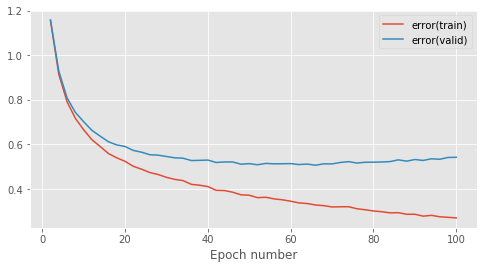

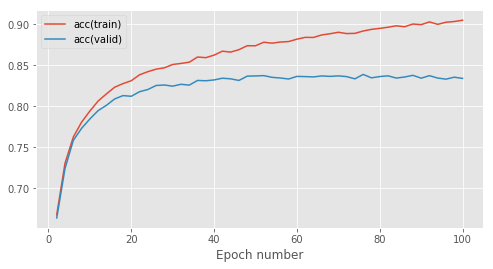

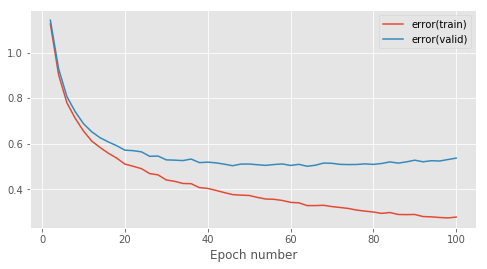

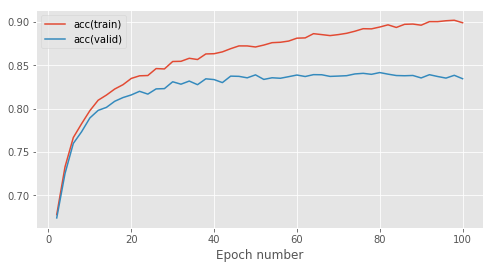

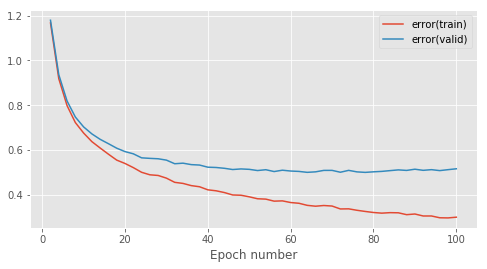

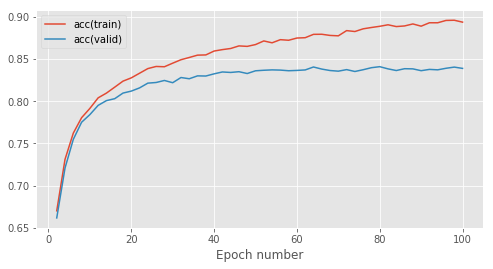

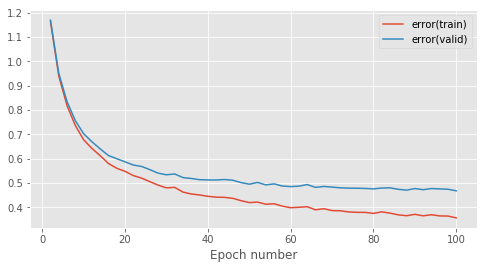

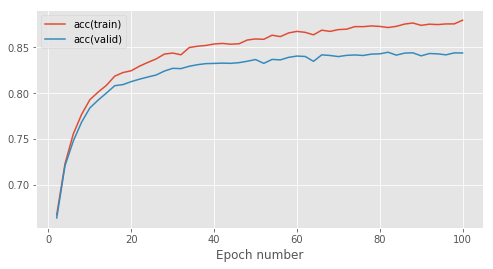

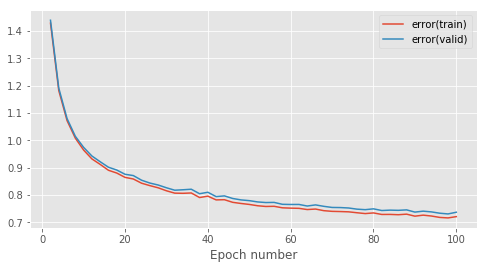

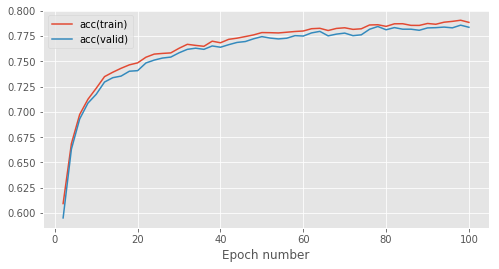

In [14]:
# Simple model with SGD and 3 hidden layers. To be used as baseline

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.learning_rules import AdamLearningRule
from mlp.schedulers import ConstantLearningRateScheduler, CosineAnnealingWithWarmRestarts
from mlp.optimisers import Optimiser
from mlp.penalties import L2Penalty


#setup hyperparameters
learning_rate = 0.0001
batch = 200
num_epochs = 100
stats_interval = 2
input_dim, output_dim, hidden_dim = 784, 47, 100

l2s = [10e-7, 10e-6, 10e-5, 10e-4, 10e-3]
# l2s = [10e-6]
res_l2 = []

for l2 in l2s:
    print("using L2=", l2)
    train_data.reset()
    valid_data.reset()
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init, weights_penalty=L2Penalty(l2)), 
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty=L2Penalty(l2)), 
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty=L2Penalty(l2)), 
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init, weights_penalty=L2Penalty(l2)), 
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init, weights_penalty=L2Penalty(l2))
    ])

    error = CrossEntropySoftmaxError()
    # Use a basic gradient descent learning rule
    learning_rule = AdamLearningRule(learning_rate=learning_rate)
    
    scheduler = ConstantLearningRateScheduler(learning_rate=learning_rate)

    #Remember to use notebook=False when you write a script to be run in a terminal
    res = train_model_and_plot_stats(
        model, error, learning_rule, train_data, scheduler, valid_data, num_epochs, stats_interval, notebook=True)
    
    res_l2.append(res)

Using weight decay= 5e-07
Starting accuracy is OrderedDict([('errorvalid', 3.8601285260517404), ('accvalid', 0.025822784810126544)])


Epoch 2: 3.2s to complete
    error(train)=1.15e+00, acc(train)=6.71e-01, error(valid)=1.16e+00, acc(valid)=6.67e-01


Epoch 4: 3.1s to complete
    error(train)=9.11e-01, acc(train)=7.32e-01, error(valid)=9.27e-01, acc(valid)=7.27e-01


Epoch 6: 3.1s to complete
    error(train)=7.93e-01, acc(train)=7.62e-01, error(valid)=8.16e-01, acc(valid)=7.54e-01


Epoch 8: 3.2s to complete
    error(train)=7.16e-01, acc(train)=7.80e-01, error(valid)=7.44e-01, acc(valid)=7.73e-01


Epoch 10: 3.2s to complete
    error(train)=6.70e-01, acc(train)=7.94e-01, error(valid)=7.01e-01, acc(valid)=7.85e-01


Epoch 12: 3.3s to complete
    error(train)=6.30e-01, acc(train)=8.04e-01, error(valid)=6.67e-01, acc(valid)=7.93e-01


Epoch 14: 3.2s to complete
    error(train)=6.03e-01, acc(train)=8.10e-01, error(valid)=6.47e-01, acc(valid)=7.97e-01


Epoch 16: 3.3s to complete
    error(train)=5.69e-01, acc(train)=8.20e-01, error(valid)=6.18e-01, acc(valid)=8.07e-01


Epoch 18: 3.2s to complete
    error(train)=5.50e-01, acc(train)=8.22e-01, error(valid)=6.04e-01, acc(valid)=8.09e-01


Epoch 20: 3.2s to complete
    error(train)=5.35e-01, acc(train)=8.28e-01, error(valid)=5.98e-01, acc(valid)=8.09e-01


Epoch 22: 3.2s to complete
    error(train)=5.10e-01, acc(train)=8.36e-01, error(valid)=5.76e-01, acc(valid)=8.17e-01


Epoch 24: 3.2s to complete
    error(train)=4.97e-01, acc(train)=8.39e-01, error(valid)=5.66e-01, acc(valid)=8.22e-01


Epoch 26: 3.2s to complete
    error(train)=4.85e-01, acc(train)=8.42e-01, error(valid)=5.62e-01, acc(valid)=8.23e-01


Epoch 28: 3.2s to complete
    error(train)=4.76e-01, acc(train)=8.43e-01, error(valid)=5.55e-01, acc(valid)=8.24e-01


Epoch 30: 3.2s to complete
    error(train)=4.62e-01, acc(train)=8.48e-01, error(valid)=5.47e-01, acc(valid)=8.24e-01


Epoch 32: 3.2s to complete
    error(train)=4.48e-01, acc(train)=8.52e-01, error(valid)=5.38e-01, acc(valid)=8.27e-01


Epoch 34: 3.2s to complete
    error(train)=4.39e-01, acc(train)=8.55e-01, error(valid)=5.37e-01, acc(valid)=8.28e-01


Epoch 36: 3.3s to complete
    error(train)=4.31e-01, acc(train)=8.56e-01, error(valid)=5.31e-01, acc(valid)=8.30e-01


Epoch 38: 3.2s to complete
    error(train)=4.25e-01, acc(train)=8.59e-01, error(valid)=5.31e-01, acc(valid)=8.26e-01


Epoch 40: 3.2s to complete
    error(train)=4.15e-01, acc(train)=8.61e-01, error(valid)=5.25e-01, acc(valid)=8.32e-01


Epoch 42: 3.2s to complete
    error(train)=4.13e-01, acc(train)=8.61e-01, error(valid)=5.25e-01, acc(valid)=8.32e-01


Epoch 44: 3.2s to complete
    error(train)=4.05e-01, acc(train)=8.65e-01, error(valid)=5.22e-01, acc(valid)=8.33e-01


Epoch 46: 3.2s to complete
    error(train)=3.93e-01, acc(train)=8.66e-01, error(valid)=5.18e-01, acc(valid)=8.30e-01


Epoch 48: 3.2s to complete
    error(train)=3.87e-01, acc(train)=8.69e-01, error(valid)=5.13e-01, acc(valid)=8.33e-01


Epoch 50: 3.2s to complete
    error(train)=3.80e-01, acc(train)=8.71e-01, error(valid)=5.12e-01, acc(valid)=8.34e-01


Epoch 52: 3.2s to complete
    error(train)=3.74e-01, acc(train)=8.73e-01, error(valid)=5.11e-01, acc(valid)=8.36e-01


Epoch 54: 3.3s to complete
    error(train)=3.71e-01, acc(train)=8.74e-01, error(valid)=5.14e-01, acc(valid)=8.36e-01


Epoch 56: 3.2s to complete
    error(train)=3.79e-01, acc(train)=8.70e-01, error(valid)=5.25e-01, acc(valid)=8.32e-01


Epoch 58: 3.2s to complete
    error(train)=3.61e-01, acc(train)=8.77e-01, error(valid)=5.12e-01, acc(valid)=8.35e-01


Epoch 60: 3.2s to complete
    error(train)=3.54e-01, acc(train)=8.79e-01, error(valid)=5.11e-01, acc(valid)=8.36e-01


Epoch 62: 3.3s to complete
    error(train)=3.51e-01, acc(train)=8.80e-01, error(valid)=5.11e-01, acc(valid)=8.37e-01


Epoch 64: 3.2s to complete
    error(train)=3.41e-01, acc(train)=8.83e-01, error(valid)=5.06e-01, acc(valid)=8.38e-01


Epoch 66: 3.2s to complete
    error(train)=3.43e-01, acc(train)=8.81e-01, error(valid)=5.14e-01, acc(valid)=8.37e-01


Epoch 68: 3.2s to complete
    error(train)=3.37e-01, acc(train)=8.84e-01, error(valid)=5.14e-01, acc(valid)=8.37e-01


Epoch 70: 3.2s to complete
    error(train)=3.37e-01, acc(train)=8.83e-01, error(valid)=5.17e-01, acc(valid)=8.37e-01


Epoch 72: 3.2s to complete
    error(train)=3.29e-01, acc(train)=8.86e-01, error(valid)=5.12e-01, acc(valid)=8.37e-01


Epoch 74: 3.2s to complete
    error(train)=3.29e-01, acc(train)=8.85e-01, error(valid)=5.17e-01, acc(valid)=8.35e-01


Epoch 76: 3.5s to complete
    error(train)=3.34e-01, acc(train)=8.82e-01, error(valid)=5.27e-01, acc(valid)=8.33e-01


Epoch 78: 3.4s to complete
    error(train)=3.19e-01, acc(train)=8.89e-01, error(valid)=5.15e-01, acc(valid)=8.39e-01


Epoch 80: 3.3s to complete
    error(train)=3.18e-01, acc(train)=8.89e-01, error(valid)=5.22e-01, acc(valid)=8.36e-01


Epoch 82: 3.3s to complete
    error(train)=3.07e-01, acc(train)=8.93e-01, error(valid)=5.14e-01, acc(valid)=8.37e-01


Epoch 84: 3.3s to complete
    error(train)=3.05e-01, acc(train)=8.93e-01, error(valid)=5.18e-01, acc(valid)=8.36e-01


Epoch 86: 3.2s to complete
    error(train)=3.01e-01, acc(train)=8.94e-01, error(valid)=5.17e-01, acc(valid)=8.38e-01


Epoch 88: 3.2s to complete
    error(train)=3.00e-01, acc(train)=8.95e-01, error(valid)=5.17e-01, acc(valid)=8.38e-01


Epoch 90: 3.2s to complete
    error(train)=3.00e-01, acc(train)=8.94e-01, error(valid)=5.28e-01, acc(valid)=8.34e-01


Epoch 92: 3.2s to complete
    error(train)=2.96e-01, acc(train)=8.96e-01, error(valid)=5.28e-01, acc(valid)=8.37e-01


Epoch 94: 3.3s to complete
    error(train)=2.87e-01, acc(train)=8.99e-01, error(valid)=5.20e-01, acc(valid)=8.36e-01


Epoch 96: 3.2s to complete
    error(train)=2.92e-01, acc(train)=8.97e-01, error(valid)=5.33e-01, acc(valid)=8.35e-01


Epoch 98: 3.2s to complete
    error(train)=2.88e-01, acc(train)=8.99e-01, error(valid)=5.31e-01, acc(valid)=8.34e-01


Epoch 100: 3.2s to complete
    error(train)=2.80e-01, acc(train)=9.02e-01, error(valid)=5.31e-01, acc(valid)=8.37e-01



Using weight decay= 5e-06
Starting accuracy is OrderedDict([('errorvalid', 3.867739970374979), ('accvalid', 0.01898734177215188)])


Epoch 2: 3.0s to complete
    error(train)=1.11e+00, acc(train)=6.80e-01, error(valid)=1.12e+00, acc(valid)=6.74e-01


Epoch 4: 3.0s to complete
    error(train)=8.81e-01, acc(train)=7.40e-01, error(valid)=8.93e-01, acc(valid)=7.36e-01


Epoch 6: 3.0s to complete
    error(train)=7.66e-01, acc(train)=7.70e-01, error(valid)=7.85e-01, acc(valid)=7.63e-01


Epoch 8: 3.1s to complete
    error(train)=7.00e-01, acc(train)=7.86e-01, error(valid)=7.23e-01, acc(valid)=7.79e-01


Epoch 10: 3.1s to complete
    error(train)=6.45e-01, acc(train)=8.00e-01, error(valid)=6.76e-01, acc(valid)=7.92e-01


Epoch 12: 3.3s to complete
    error(train)=6.12e-01, acc(train)=8.09e-01, error(valid)=6.52e-01, acc(valid)=7.99e-01


Epoch 14: 3.2s to complete
    error(train)=5.84e-01, acc(train)=8.16e-01, error(valid)=6.28e-01, acc(valid)=8.04e-01


Epoch 16: 3.1s to complete
    error(train)=5.67e-01, acc(train)=8.20e-01, error(valid)=6.15e-01, acc(valid)=8.04e-01


Epoch 18: 3.2s to complete
    error(train)=5.42e-01, acc(train)=8.26e-01, error(valid)=5.96e-01, acc(valid)=8.10e-01


Epoch 20: 3.4s to complete
    error(train)=5.29e-01, acc(train)=8.31e-01, error(valid)=5.88e-01, acc(valid)=8.14e-01


Epoch 22: 3.4s to complete
    error(train)=5.04e-01, acc(train)=8.38e-01, error(valid)=5.66e-01, acc(valid)=8.19e-01


Epoch 24: 3.4s to complete
    error(train)=4.94e-01, acc(train)=8.41e-01, error(valid)=5.62e-01, acc(valid)=8.21e-01


Epoch 26: 3.3s to complete
    error(train)=4.82e-01, acc(train)=8.44e-01, error(valid)=5.52e-01, acc(valid)=8.24e-01


Epoch 28: 3.3s to complete
    error(train)=4.78e-01, acc(train)=8.43e-01, error(valid)=5.52e-01, acc(valid)=8.21e-01


Epoch 30: 3.2s to complete
    error(train)=4.62e-01, acc(train)=8.49e-01, error(valid)=5.37e-01, acc(valid)=8.27e-01


Epoch 32: 3.2s to complete
    error(train)=4.52e-01, acc(train)=8.51e-01, error(valid)=5.34e-01, acc(valid)=8.26e-01


Epoch 34: 3.2s to complete
    error(train)=4.43e-01, acc(train)=8.53e-01, error(valid)=5.27e-01, acc(valid)=8.30e-01


Epoch 36: 3.2s to complete
    error(train)=4.36e-01, acc(train)=8.55e-01, error(valid)=5.22e-01, acc(valid)=8.30e-01


Epoch 38: 3.4s to complete
    error(train)=4.25e-01, acc(train)=8.60e-01, error(valid)=5.16e-01, acc(valid)=8.34e-01


Epoch 40: 3.4s to complete
    error(train)=4.20e-01, acc(train)=8.60e-01, error(valid)=5.13e-01, acc(valid)=8.34e-01


Epoch 42: 3.2s to complete
    error(train)=4.14e-01, acc(train)=8.62e-01, error(valid)=5.11e-01, acc(valid)=8.34e-01


Epoch 44: 3.2s to complete
    error(train)=4.11e-01, acc(train)=8.61e-01, error(valid)=5.12e-01, acc(valid)=8.32e-01


Epoch 46: 3.2s to complete
    error(train)=4.05e-01, acc(train)=8.63e-01, error(valid)=5.10e-01, acc(valid)=8.34e-01


Epoch 48: 3.2s to complete
    error(train)=4.00e-01, acc(train)=8.65e-01, error(valid)=5.04e-01, acc(valid)=8.36e-01


Epoch 50: 3.1s to complete
    error(train)=3.88e-01, acc(train)=8.69e-01, error(valid)=4.93e-01, acc(valid)=8.39e-01


Epoch 52: 3.2s to complete
    error(train)=3.87e-01, acc(train)=8.70e-01, error(valid)=4.97e-01, acc(valid)=8.39e-01


Epoch 54: 3.1s to complete
    error(train)=3.80e-01, acc(train)=8.71e-01, error(valid)=4.95e-01, acc(valid)=8.39e-01


Epoch 56: 3.1s to complete
    error(train)=3.80e-01, acc(train)=8.70e-01, error(valid)=4.94e-01, acc(valid)=8.38e-01


Epoch 58: 3.2s to complete
    error(train)=3.73e-01, acc(train)=8.73e-01, error(valid)=4.89e-01, acc(valid)=8.41e-01


Epoch 60: 3.2s to complete
    error(train)=3.68e-01, acc(train)=8.75e-01, error(valid)=4.89e-01, acc(valid)=8.39e-01


Epoch 62: 3.2s to complete
    error(train)=3.66e-01, acc(train)=8.75e-01, error(valid)=4.89e-01, acc(valid)=8.41e-01


Epoch 64: 3.2s to complete
    error(train)=3.64e-01, acc(train)=8.75e-01, error(valid)=4.89e-01, acc(valid)=8.38e-01


Epoch 66: 3.2s to complete
    error(train)=3.60e-01, acc(train)=8.76e-01, error(valid)=4.88e-01, acc(valid)=8.39e-01


Epoch 68: 3.2s to complete
    error(train)=3.54e-01, acc(train)=8.79e-01, error(valid)=4.84e-01, acc(valid)=8.40e-01


Epoch 70: 3.2s to complete
    error(train)=3.49e-01, acc(train)=8.81e-01, error(valid)=4.78e-01, acc(valid)=8.44e-01


Epoch 72: 3.2s to complete
    error(train)=3.46e-01, acc(train)=8.82e-01, error(valid)=4.84e-01, acc(valid)=8.42e-01


Epoch 74: 3.5s to complete
    error(train)=3.43e-01, acc(train)=8.82e-01, error(valid)=4.80e-01, acc(valid)=8.43e-01


Epoch 76: 3.2s to complete
    error(train)=3.43e-01, acc(train)=8.83e-01, error(valid)=4.79e-01, acc(valid)=8.42e-01


Epoch 78: 3.3s to complete
    error(train)=3.41e-01, acc(train)=8.82e-01, error(valid)=4.82e-01, acc(valid)=8.44e-01


Epoch 80: 3.1s to complete
    error(train)=3.37e-01, acc(train)=8.83e-01, error(valid)=4.78e-01, acc(valid)=8.44e-01


Epoch 82: 3.2s to complete
    error(train)=3.37e-01, acc(train)=8.83e-01, error(valid)=4.85e-01, acc(valid)=8.42e-01


Epoch 84: 3.2s to complete
    error(train)=3.31e-01, acc(train)=8.85e-01, error(valid)=4.80e-01, acc(valid)=8.44e-01


Epoch 86: 3.2s to complete
    error(train)=3.27e-01, acc(train)=8.86e-01, error(valid)=4.76e-01, acc(valid)=8.44e-01


Epoch 88: 3.2s to complete
    error(train)=3.21e-01, acc(train)=8.89e-01, error(valid)=4.76e-01, acc(valid)=8.45e-01


Epoch 90: 3.3s to complete
    error(train)=3.18e-01, acc(train)=8.90e-01, error(valid)=4.72e-01, acc(valid)=8.46e-01


Epoch 92: 3.3s to complete
    error(train)=3.19e-01, acc(train)=8.90e-01, error(valid)=4.78e-01, acc(valid)=8.47e-01


Epoch 94: 3.2s to complete
    error(train)=3.16e-01, acc(train)=8.91e-01, error(valid)=4.74e-01, acc(valid)=8.48e-01


Epoch 96: 3.2s to complete
    error(train)=3.11e-01, acc(train)=8.92e-01, error(valid)=4.74e-01, acc(valid)=8.48e-01


Epoch 98: 3.4s to complete
    error(train)=3.18e-01, acc(train)=8.88e-01, error(valid)=4.84e-01, acc(valid)=8.40e-01


Epoch 100: 3.5s to complete
    error(train)=3.06e-01, acc(train)=8.94e-01, error(valid)=4.73e-01, acc(valid)=8.47e-01


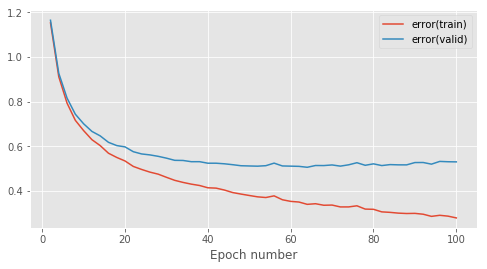

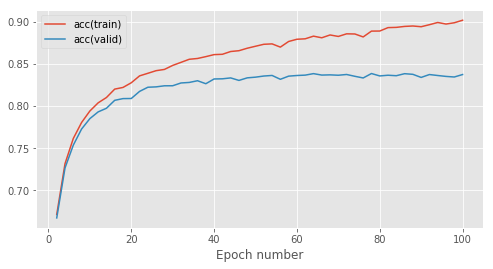

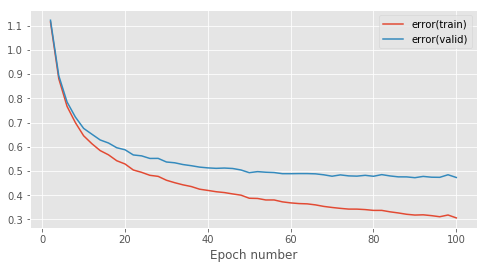

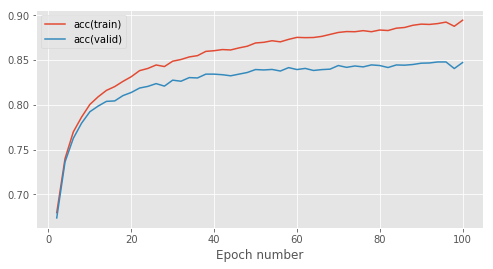

In [36]:
# Simple model with SGD and 3 hidden layers. To be used as baseline

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.learning_rules import AdamLearningRuleWithWeightDecay
from mlp.schedulers import ConstantLearningRateScheduler, CosineAnnealingWithWarmRestarts
from mlp.optimisers import Optimiser
from mlp.penalties import L2Penalty


#setup hyperparameters
learning_rate = 0.0001
batch = 200
num_epochs = 100
stats_interval = 2
input_dim, output_dim, hidden_dim = 784, 47, 100

# wds = [10e-7, 10e-6, 10e-5, 10e-4, 10e-3]
wds = [5e-7, 5e-6]
# res_wd = []

for wd in wds:
    print("Using weight decay=", wd)
    train_data.reset()
    valid_data.reset()
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ])

    error = CrossEntropySoftmaxError()
    # Use a basic gradient descent learning rule
    learning_rule = AdamLearningRuleWithWeightDecay(learning_rate=learning_rate, weight_decay=wd)
    
    scheduler = ConstantLearningRateScheduler(learning_rate=learning_rate)

    #Remember to use notebook=False when you write a script to be run in a terminal
    res = train_model_and_plot_stats(
        model, error, learning_rule, train_data, scheduler, valid_data, num_epochs, stats_interval, notebook=True)
    
    res_wd.append(res)

In [27]:
top_res = [res_vanila, res_l2[-1][0], res_wd[1][0]]
top_res_str = ["No regularisation", "L2 regularisation", "Weight decay"]

Training time is 361.1353671550751
Error in train 0.8987999999999956
Error in valid 0.8349367088607591
Training time is 363.95700693130493
Error in train 0.8810199999999987
Error in valid 0.8427848101265817
Training time is 358.4017159938812
Error in train 0.7830699999999972
Error in valid 0.7757594936708863
Training time is 378.3326723575592
Error in train 0.3650200000000004
Error in valid 0.35873417721518985
Training time is 1376.551709651947
Error in train 0.02143999999999995
Error in valid 0.018860759493670866
Training time is 360.987735748291
Error in train 0.9017499999999948
Error in valid 0.837341772151899
Training time is 360.62304186820984
Error in train 0.8943299999999963
Error in valid 0.8470886075949365


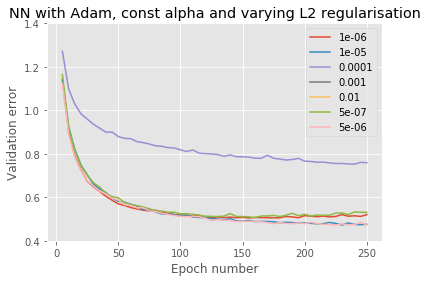

In [38]:
# plot the results from multile experiments onto one plot
# fig_1 = plt.figure(figsize=(6, 4))
# ax_1 = fig_1.add_subplot(111)

fig, axs = plt.subplots(1,1, figsize=(6, 4))
top_res_str = ["Const alpha", "Cos anneal with restart", "Cos anneal no restart"]
wds = [10e-7, 10e-6, 10e-5, 10e-4, 10e-3, 5e-7, 5e-6]

for idx, each in enumerate(res_wd):
    stats, keys, run_time, _, _, _, _, _ = each
    error_valid = stats[:,keys['acc(valid)']][-1]
    error_train = stats[:,keys['acc(train)']][-1]
    print("Training time is", each[2])
    print("Error in train", error_train)
    print("Error in valid", error_valid)
    axs.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys["error(valid)"]], label=str(wds[idx]))
    axs.legend(loc=0)
    axs.set_xlabel('Epoch number')
    axs.set_ylabel('Validation error')
    axs.set_ylim((0.4, 1.4))
    axs.set_title('NN with Adam, const alpha and varying L2 regularisation')
                        
#     plt.savefig("ex4_l2_comparison.pdf")

Training time is 341.48922538757324
Error in train 0.9035999999999954
Error in valid 0.8368354430379745
Training time is 669.8972918987274
Error in train 0.879729999999998
Error in valid 0.8439240506329112
Training time is 363.95700693130493
Error in train 0.8810199999999987
Error in valid 0.8427848101265817


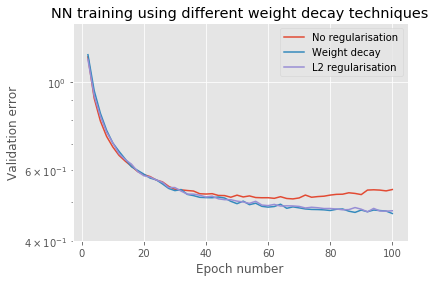

In [35]:
# plot the results from multile experiments onto one plot
top_res = [res_vanila, res_l2[-2], res_wd[1]]
top_res_str = ["No regularisation", "Weight decay", "L2 regularisation"]

fig, axs = plt.subplots(1,1, figsize=(6, 4))

for idx, each in enumerate(top_res):
    stats, keys, run_time, _, _, _, _, _ = each
    error_valid = stats[:,keys['acc(valid)']][-1]
    error_train = stats[:,keys['acc(train)']][-1]
    print("Training time is", each[2])
    print("Error in train", error_train)
    print("Error in valid", error_valid)
    axs.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys["error(valid)"]], label=top_res_str[idx])
    axs.legend(loc=0)
    axs.set_xlabel('Epoch number')
    axs.set_ylabel('Validation error')
    axs.set_yscale('log')
    axs.set_ylim((0.4, 1.4))
    axs.set_title('NN training using different weight decay techniques')
                        
    plt.savefig("ex4_l2_vs_wd.pdf")

## Part 2
Explore effect of different learning rate schedulers.

Already have the vanila results, now explore with and without warm restarts.

Starting accuracy is OrderedDict([('errorvalid', 3.852675369480724), ('accvalid', 0.02208860759493668)])


Epoch 5: 5.6s to complete
    error(train)=8.65e-01, acc(train)=7.45e-01, error(valid)=8.80e-01, acc(valid)=7.44e-01


Epoch 10: 5.1s to complete
    error(train)=6.94e-01, acc(train)=7.88e-01, error(valid)=7.18e-01, acc(valid)=7.82e-01


Epoch 15: 4.6s to complete
    error(train)=6.16e-01, acc(train)=8.05e-01, error(valid)=6.52e-01, acc(valid)=7.94e-01


Epoch 20: 4.4s to complete
    error(train)=5.59e-01, acc(train)=8.23e-01, error(valid)=6.03e-01, acc(valid)=8.12e-01


Epoch 25: 5.2s to complete
    error(train)=5.23e-01, acc(train)=8.33e-01, error(valid)=5.76e-01, acc(valid)=8.17e-01


Epoch 30: 5.9s to complete
    error(train)=4.95e-01, acc(train)=8.40e-01, error(valid)=5.56e-01, acc(valid)=8.19e-01


Epoch 35: 4.8s to complete
    error(train)=4.77e-01, acc(train)=8.45e-01, error(valid)=5.43e-01, acc(valid)=8.24e-01


Epoch 40: 4.7s to complete
    error(train)=4.55e-01, acc(train)=8.53e-01, error(valid)=5.30e-01, acc(valid)=8.29e-01


Epoch 45: 4.5s to complete
    error(train)=4.41e-01, acc(train)=8.55e-01, error(valid)=5.21e-01, acc(valid)=8.31e-01


Epoch 50: 5.5s to complete
    error(train)=4.33e-01, acc(train)=8.56e-01, error(valid)=5.15e-01, acc(valid)=8.30e-01


Epoch 55: 4.3s to complete
    error(train)=4.18e-01, acc(train)=8.61e-01, error(valid)=5.04e-01, acc(valid)=8.34e-01


Epoch 60: 4.4s to complete
    error(train)=4.10e-01, acc(train)=8.64e-01, error(valid)=5.02e-01, acc(valid)=8.34e-01


Epoch 65: 4.5s to complete
    error(train)=3.97e-01, acc(train)=8.69e-01, error(valid)=4.91e-01, acc(valid)=8.38e-01


Epoch 70: 5.1s to complete
    error(train)=3.90e-01, acc(train)=8.69e-01, error(valid)=4.89e-01, acc(valid)=8.38e-01


Epoch 75: 4.5s to complete
    error(train)=3.86e-01, acc(train)=8.71e-01, error(valid)=4.90e-01, acc(valid)=8.38e-01


Epoch 80: 4.3s to complete
    error(train)=3.77e-01, acc(train)=8.73e-01, error(valid)=4.86e-01, acc(valid)=8.39e-01


Epoch 85: 5.0s to complete
    error(train)=3.70e-01, acc(train)=8.75e-01, error(valid)=4.80e-01, acc(valid)=8.39e-01


Epoch 90: 4.4s to complete
    error(train)=3.67e-01, acc(train)=8.75e-01, error(valid)=4.78e-01, acc(valid)=8.40e-01


Epoch 95: 4.8s to complete
    error(train)=3.63e-01, acc(train)=8.77e-01, error(valid)=4.80e-01, acc(valid)=8.41e-01


Epoch 100: 4.3s to complete
    error(train)=3.61e-01, acc(train)=8.77e-01, error(valid)=4.80e-01, acc(valid)=8.39e-01



Starting accuracy is OrderedDict([('errorvalid', 3.859489207199233), ('accvalid', 0.02183544303797465)])


Epoch 5: 3.1s to complete
    error(train)=8.46e-01, acc(train)=7.48e-01, error(valid)=8.62e-01, acc(valid)=7.48e-01


Epoch 10: 3.4s to complete
    error(train)=6.73e-01, acc(train)=7.93e-01, error(valid)=7.00e-01, acc(valid)=7.87e-01


Epoch 15: 3.3s to complete
    error(train)=6.01e-01, acc(train)=8.11e-01, error(valid)=6.40e-01, acc(valid)=7.98e-01


Epoch 20: 3.7s to complete
    error(train)=5.41e-01, acc(train)=8.29e-01, error(valid)=5.86e-01, acc(valid)=8.14e-01


Epoch 25: 3.4s to complete
    error(train)=5.11e-01, acc(train)=8.36e-01, error(valid)=5.64e-01, acc(valid)=8.21e-01


Epoch 30: 3.3s to complete
    error(train)=4.78e-01, acc(train)=8.46e-01, error(valid)=5.38e-01, acc(valid)=8.25e-01


Epoch 35: 3.3s to complete
    error(train)=4.64e-01, acc(train)=8.49e-01, error(valid)=5.30e-01, acc(valid)=8.26e-01


Epoch 40: 3.2s to complete
    error(train)=4.48e-01, acc(train)=8.53e-01, error(valid)=5.20e-01, acc(valid)=8.33e-01


Epoch 45: 3.3s to complete
    error(train)=4.30e-01, acc(train)=8.59e-01, error(valid)=5.05e-01, acc(valid)=8.33e-01


Epoch 50: 3.1s to complete
    error(train)=4.19e-01, acc(train)=8.62e-01, error(valid)=4.98e-01, acc(valid)=8.38e-01


Epoch 55: 3.2s to complete
    error(train)=4.09e-01, acc(train)=8.64e-01, error(valid)=4.91e-01, acc(valid)=8.38e-01


Epoch 60: 3.3s to complete
    error(train)=4.03e-01, acc(train)=8.65e-01, error(valid)=4.90e-01, acc(valid)=8.35e-01


Epoch 65: 3.4s to complete
    error(train)=3.93e-01, acc(train)=8.69e-01, error(valid)=4.83e-01, acc(valid)=8.40e-01


Epoch 70: 3.2s to complete
    error(train)=3.85e-01, acc(train)=8.72e-01, error(valid)=4.80e-01, acc(valid)=8.41e-01


Epoch 75: 3.2s to complete
    error(train)=3.77e-01, acc(train)=8.74e-01, error(valid)=4.74e-01, acc(valid)=8.42e-01


Epoch 80: 3.4s to complete
    error(train)=3.74e-01, acc(train)=8.74e-01, error(valid)=4.73e-01, acc(valid)=8.43e-01


Epoch 85: 3.3s to complete
    error(train)=3.69e-01, acc(train)=8.75e-01, error(valid)=4.74e-01, acc(valid)=8.42e-01


Epoch 90: 3.8s to complete
    error(train)=3.59e-01, acc(train)=8.78e-01, error(valid)=4.65e-01, acc(valid)=8.47e-01


Epoch 95: 5.7s to complete
    error(train)=3.56e-01, acc(train)=8.80e-01, error(valid)=4.66e-01, acc(valid)=8.46e-01


Epoch 100: 4.4s to complete
    error(train)=3.50e-01, acc(train)=8.81e-01, error(valid)=4.63e-01, acc(valid)=8.46e-01



Starting accuracy is OrderedDict([('errorvalid', 3.8567321357909594), ('accvalid', 0.02379746835443035)])


Epoch 5: 4.4s to complete
    error(train)=1.38e+00, acc(train)=6.20e-01, error(valid)=1.38e+00, acc(valid)=6.17e-01


Epoch 10: 5.9s to complete
    error(train)=1.27e+00, acc(train)=6.48e-01, error(valid)=1.28e+00, acc(valid)=6.43e-01


Epoch 15: 4.4s to complete
    error(train)=1.10e+00, acc(train)=6.90e-01, error(valid)=1.11e+00, acc(valid)=6.87e-01


Epoch 20: 5.7s to complete
    error(train)=1.07e+00, acc(train)=7.03e-01, error(valid)=1.08e+00, acc(valid)=6.98e-01


Epoch 25: 4.3s to complete
    error(train)=1.12e+00, acc(train)=7.03e-01, error(valid)=1.13e+00, acc(valid)=6.98e-01


Epoch 30: 4.4s to complete
    error(train)=1.04e+00, acc(train)=7.07e-01, error(valid)=1.05e+00, acc(valid)=7.03e-01


Epoch 35: 4.3s to complete
    error(train)=9.50e-01, acc(train)=7.29e-01, error(valid)=9.59e-01, acc(valid)=7.24e-01


Epoch 40: 4.8s to complete
    error(train)=9.03e-01, acc(train)=7.40e-01, error(valid)=9.13e-01, acc(valid)=7.37e-01


Epoch 45: 5.7s to complete
    error(train)=8.79e-01, acc(train)=7.47e-01, error(valid)=8.89e-01, acc(valid)=7.42e-01


Epoch 50: 5.4s to complete
    error(train)=8.71e-01, acc(train)=7.51e-01, error(valid)=8.81e-01, acc(valid)=7.46e-01


Epoch 55: 5.0s to complete
    error(train)=8.79e-01, acc(train)=7.51e-01, error(valid)=8.89e-01, acc(valid)=7.48e-01


Epoch 60: 4.5s to complete
    error(train)=9.04e-01, acc(train)=7.50e-01, error(valid)=9.13e-01, acc(valid)=7.44e-01


Epoch 65: 4.6s to complete
    error(train)=9.47e-01, acc(train)=7.46e-01, error(valid)=9.57e-01, acc(valid)=7.40e-01


Epoch 70: 5.3s to complete
    error(train)=1.01e+00, acc(train)=7.41e-01, error(valid)=1.02e+00, acc(valid)=7.36e-01


Epoch 75: 4.3s to complete
    error(train)=1.10e+00, acc(train)=7.35e-01, error(valid)=1.11e+00, acc(valid)=7.31e-01


Epoch 80: 4.3s to complete
    error(train)=1.22e+00, acc(train)=7.27e-01, error(valid)=1.23e+00, acc(valid)=7.23e-01


Epoch 85: 5.1s to complete
    error(train)=9.76e-01, acc(train)=7.27e-01, error(valid)=9.83e-01, acc(valid)=7.22e-01


Epoch 90: 4.5s to complete
    error(train)=8.91e-01, acc(train)=7.43e-01, error(valid)=8.98e-01, acc(valid)=7.37e-01


Epoch 95: 4.5s to complete
    error(train)=8.53e-01, acc(train)=7.52e-01, error(valid)=8.60e-01, acc(valid)=7.47e-01


Epoch 100: 4.4s to complete
    error(train)=8.29e-01, acc(train)=7.58e-01, error(valid)=8.39e-01, acc(valid)=7.52e-01



Starting accuracy is OrderedDict([('errorvalid', 3.8613403031527036), ('accvalid', 0.020632911392405032)])


Epoch 5: 4.6s to complete
    error(train)=1.44e+00, acc(train)=6.05e-01, error(valid)=1.44e+00, acc(valid)=6.02e-01


Epoch 10: 4.1s to complete
    error(train)=1.30e+00, acc(train)=6.42e-01, error(valid)=1.31e+00, acc(valid)=6.39e-01


Epoch 15: 4.3s to complete
    error(train)=1.11e+00, acc(train)=6.88e-01, error(valid)=1.12e+00, acc(valid)=6.84e-01


Epoch 20: 4.3s to complete
    error(train)=1.07e+00, acc(train)=7.02e-01, error(valid)=1.08e+00, acc(valid)=6.98e-01


Epoch 25: 4.1s to complete
    error(train)=1.13e+00, acc(train)=7.02e-01, error(valid)=1.14e+00, acc(valid)=6.97e-01


Epoch 30: 4.2s to complete
    error(train)=1.04e+00, acc(train)=7.07e-01, error(valid)=1.05e+00, acc(valid)=7.04e-01


Epoch 35: 4.1s to complete
    error(train)=9.52e-01, acc(train)=7.27e-01, error(valid)=9.63e-01, acc(valid)=7.24e-01


Epoch 40: 4.5s to complete
    error(train)=9.09e-01, acc(train)=7.37e-01, error(valid)=9.21e-01, acc(valid)=7.34e-01


Epoch 45: 4.2s to complete
    error(train)=8.82e-01, acc(train)=7.46e-01, error(valid)=8.94e-01, acc(valid)=7.43e-01


Epoch 50: 4.5s to complete
    error(train)=8.74e-01, acc(train)=7.50e-01, error(valid)=8.86e-01, acc(valid)=7.48e-01


Epoch 55: 6.0s to complete
    error(train)=8.83e-01, acc(train)=7.50e-01, error(valid)=8.95e-01, acc(valid)=7.47e-01


Epoch 60: 4.1s to complete
    error(train)=9.07e-01, acc(train)=7.49e-01, error(valid)=9.19e-01, acc(valid)=7.45e-01


Epoch 65: 4.3s to complete
    error(train)=9.50e-01, acc(train)=7.45e-01, error(valid)=9.61e-01, acc(valid)=7.42e-01


Epoch 70: 6.0s to complete
    error(train)=1.02e+00, acc(train)=7.41e-01, error(valid)=1.03e+00, acc(valid)=7.36e-01


Epoch 75: 4.3s to complete
    error(train)=1.11e+00, acc(train)=7.34e-01, error(valid)=1.12e+00, acc(valid)=7.31e-01


Epoch 80: 5.3s to complete
    error(train)=1.22e+00, acc(train)=7.27e-01, error(valid)=1.23e+00, acc(valid)=7.23e-01


Epoch 85: 4.8s to complete
    error(train)=9.78e-01, acc(train)=7.27e-01, error(valid)=9.87e-01, acc(valid)=7.25e-01


Epoch 90: 5.0s to complete
    error(train)=8.94e-01, acc(train)=7.43e-01, error(valid)=9.03e-01, acc(valid)=7.39e-01


Epoch 95: 4.7s to complete
    error(train)=8.57e-01, acc(train)=7.51e-01, error(valid)=8.69e-01, acc(valid)=7.48e-01


Epoch 100: 4.9s to complete
    error(train)=8.32e-01, acc(train)=7.58e-01, error(valid)=8.43e-01, acc(valid)=7.53e-01


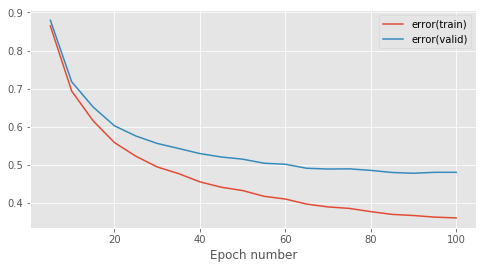

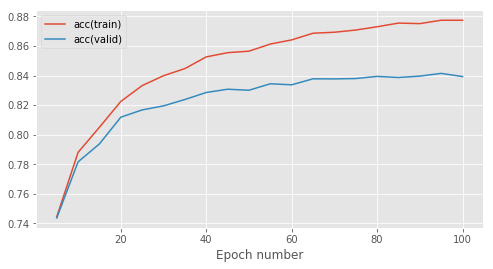

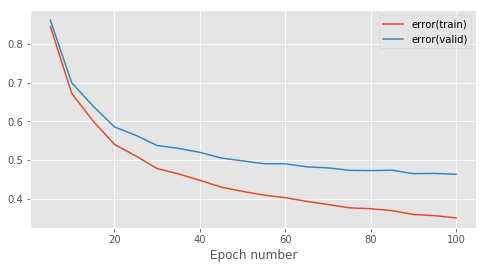

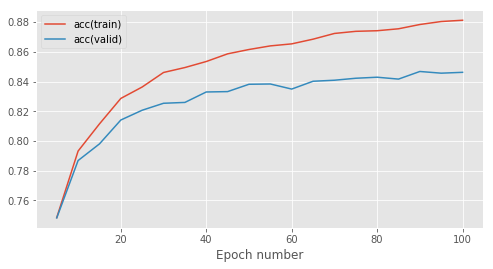

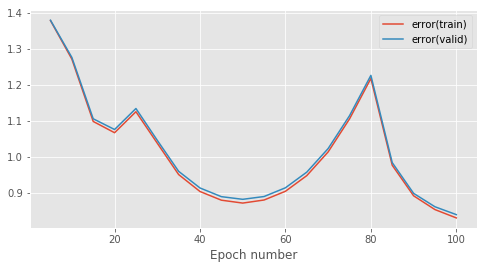

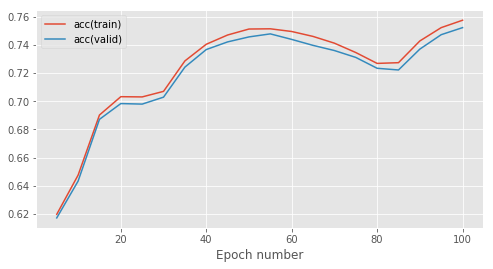

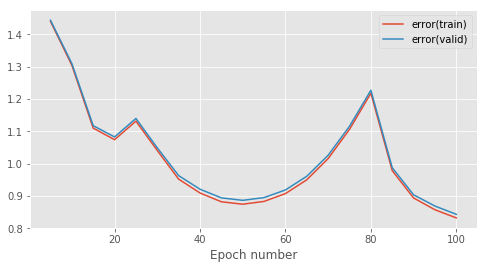

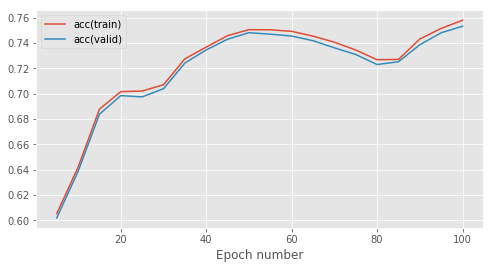

In [20]:
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.learning_rules import AdamLearningRuleWithWeightDecay
from mlp.optimisers import Optimiser
from mlp.schedulers import CosineAnnealingWithWarmRestartsPlus


res_adam_learn = []

#setup hyperparameters
learning_rate = 0.0001
batch = 100
num_epochs = 100
stats_interval = 5
wd = 1e-5
input_dim, output_dim, hidden_dim = 784, 47, 100

train_data.reset()
valid_data.reset()

schedulers_adam = [ConstantLearningRateScheduler(0.0001),
              CosineAnnealingWithWarmRestarts(min_learning_rate=0.00001, max_learning_rate=0.0001,
                                                       total_iters_per_period=10e+5,
                                                       max_learning_rate_discount_factor=0.9,
                                                       period_iteration_expansion_factor=1.0),
              CosineAnnealingWithWarmRestarts(min_learning_rate=0.00001, max_learning_rate=0.0001,
                                                       total_iters_per_period=25,
                                                       max_learning_rate_discount_factor=0.9,
                                                       period_iteration_expansion_factor=3.0),
              CosineAnnealingWithWarmRestartsPlus(min_learning_rate=0.00001, max_learning_rate=0.0001,
                                                       total_iters_per_period=25,
                                                       max_learning_rate_discount_factor=0.9,
                                                       period_iteration_expansion_factor=3.0)
             ]


for scheduler in schedulers_adam:
#     train_data.reset()
#     valid_data.reset()
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ])

    error = CrossEntropySoftmaxError()
    # Use a basic gradient descent learning rule
    learning_rule = AdamLearningRuleWithWeightDecay(learning_rate=learning_rate, weight_decay=wd)
    
    #Remember to use notebook=False when you write a script to be run in a terminal
    res = train_model_and_plot_stats(
        model, error, learning_rule, train_data, scheduler, valid_data, num_epochs, stats_interval, notebook=True)
    
    res_adam_learn.append(res)

Training time is 503.31308937072754
Error in train 0.8773699999999988
Error in valid 0.8393037974683539
Training time is 365.83043384552
Error in train 0.8812499999999991
Error in valid 0.8462025316455697
Training time is 493.8943340778351
Error in train 0.7575299999999993
Error in valid 0.7522784810126584
Training time is 474.46008944511414
Error in train 0.7578399999999984
Error in valid 0.7531012658227849


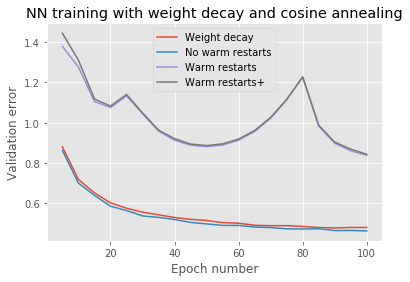

In [23]:
# plot the results from multile experiments onto one plot
top_res_str = ["Weight decay", "No warm restarts", "Warm restarts", "Warm restarts+"]

fig, axs = plt.subplots(1,1, figsize=(6, 4))

for idx, each in enumerate(res_adam_learn):
    stats, keys, run_time, _, _, _, _, _ = each
    error_valid = stats[:,keys['acc(valid)']][-1]
    error_train = stats[:,keys['acc(train)']][-1]
    print("Training time is", each[2])
    print("Error in train", error_train)
    print("Error in valid", error_valid)
    axs.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys["error(valid)"]], label=top_res_str[idx])
    axs.legend(loc=0)
    axs.set_xlabel('Epoch number')
    axs.set_ylabel('Validation error')
#     axs.set_ylim((0.4, 1.4))
    axs.set_title('NN training with weight decay and cosine annealing')
    
    plt.savefig("ex4_wd_cos_anneal.pdf")